# DATA LOADING AND EXPLORATION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
import math
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import re
from collections import Counter
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.base import clone
import lightgbm as lgb
import folium
from folium.plugins import HeatMap
import plotly.express as px
import plotly.graph_objects as go


pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', 100)

In [2]:
# Load the data
df = pd.read_csv('austinhouses.csv')  

In [3]:
def create_plotly_scatter_map(df, sample_size=2000):
    """
    Create interactive scatter plot map with Plotly
    """
    # Sample for performance
    if len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=42)
    else:
        df_sample = df.copy()
    
    # Create price in thousands for better display
    df_sample['price_k'] = df_sample['latestPrice']
    
    fig = px.scatter_mapbox(
        df_sample,
        lat="latitude",
        lon="longitude",
        color="price_k",
        size="livingAreaSqFt",
        hover_data={
            'price_k': ':,.0f',
            'livingAreaSqFt': ':,',
            'numOfBedrooms': True,
            'numOfBathrooms': True,
            'yearBuilt': True
        },
        hover_name="price_k",
        color_continuous_scale="Viridis",
        size_max=15,
        zoom=10,
        title="Austin Housing Prices by Location",
        labels={
            'price_k': 'Price ($K)',
            'livingAreaSqFt': 'Living Area (sqft)',
            'latitude': 'Latitude',
            'longitude': 'Longitude'
        }
    )
    
    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_center_lat=30.2672,
        mapbox_center_lon=-97.7431,
        height=600,
        width=800
    )
    
    return fig

In [4]:
# Method 2: Plotly scatter map
plotly_fig = create_plotly_scatter_map(df)
plotly_fig.write_html('austin_housing_prices_plotly.html')
print("✅ Plotly interactive map saved as 'austin_housing_prices_plotly.html'")

✅ Plotly interactive map saved as 'austin_housing_prices_plotly.html'


## Basic info about the dataset

In [5]:
print("Dataset Shape:", df.shape)

Dataset Shape: (6784, 35)


In [6]:
print("\nColumn Names:")
for i, col in enumerate(df.columns):
    print(f"{i+1}. {col}")

print("\nData Types:")
print(df.dtypes)

print("\nFirst 5 rows:")
print(df.head())


Column Names:
1. streetAddress
2. zipcode
3. description
4. latitude
5. longitude
6. propertyTaxRate
7. garageSpaces
8. hasAssociation
9. hasGarage
10. hasSpa
11. hasView
12. homeType
13. yearBuilt
14. latestPrice
15. latest_saledate
16. latest_salemonth
17. latest_saleyear
18. numOfPhotos
19. numOfAccessibilityFeatures
20. numOfAppliances
21. numOfParkingFeatures
22. numOfPatioAndPorchFeatures
23. numOfSecurityFeatures
24. numOfWaterfrontFeatures
25. numOfWindowFeatures
26. numOfCommunityFeatures
27. lotSizeSqFt
28. livingAreaSqFt
29. avgSchoolDistance
30. avgSchoolRating
31. avgSchoolSize
32. MedianStudentsPerTeacher
33. numOfBathrooms
34. numOfBedrooms
35. numOfStories

Data Types:
streetAddress                  object
zipcode                         int64
description                    object
latitude                      float64
longitude                     float64
propertyTaxRate               float64
garageSpaces                    int64
hasAssociation                   bool
h

- no missing/null data!

### Look at the target variable (latestPrice)


In [7]:
print("\nPrice Distribution:")
print(f"Minimum price: ${df['latestPrice'].min()*1000:,.2f}")
print(f"Maximum price: ${df['latestPrice'].max()*1000:,.2f}")
print(f"Mean price: ${df['latestPrice'].mean()*1000:,.2f}")
print(f"Median price: ${df['latestPrice'].median()*1000:,.2f}")


Price Distribution:
Minimum price: $5,800.00
Maximum price: $6,250,000.00
Mean price: $486,583.78
Median price: $400,000.00


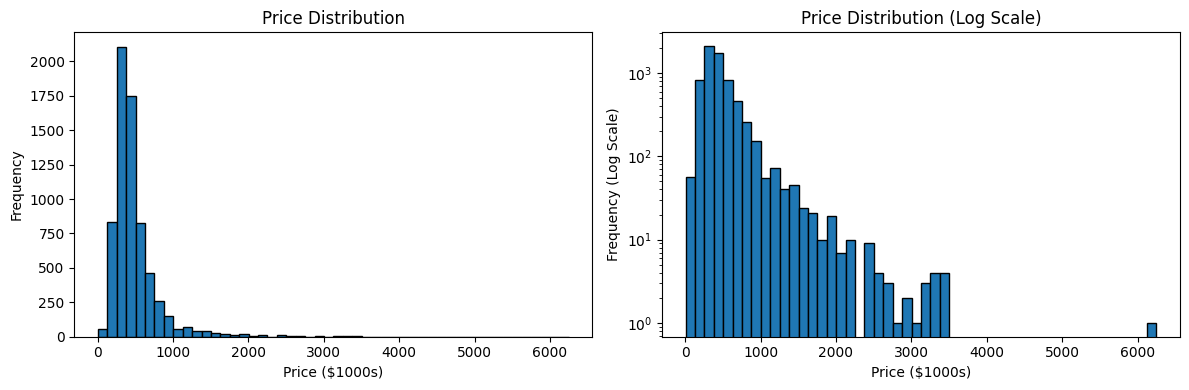

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['latestPrice'], bins=50, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price ($1000s)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['latestPrice'], bins=50, edgecolor='black')
plt.title('Price Distribution (Log Scale)')
plt.xlabel('Price ($1000s)')
plt.ylabel('Frequency (Log Scale)')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [9]:
# Look at categorical variables
print("\nCategorical Variables:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col not in ['streetAddress', 'description']:  # Skip these for now
        print(f"\n{col}:")
        print(df[col].value_counts().head())


Categorical Variables:

homeType:
Single Family    6784
Name: homeType, dtype: int64

latest_saledate:
2019-04-30    35
2020-06-30    26
2019-02-28    26
2020-09-16    25
2019-07-31    25
Name: latest_saledate, dtype: int64


- We can drop `homeType` as just has one value 'Single Family', no predictive power!
- Convert date-time object!

In [10]:
df['latest_saledate'] = pd.to_datetime(df['latest_saledate'])
df.drop(['homeType'], axis=1, inplace=True)

## DATA CLEANING AND BASIC PREPROCESSING

In [11]:
# Create a working copy
df_clean = df.copy()

In [12]:
# Remove columns we don't want as predictors (--for now, will do text NLP later if time permits)
columns_to_remove = ['streetAddress', 'description']
df_clean = df_clean.drop(columns=[col for col in columns_to_remove if col in df_clean.columns])

In [13]:
# Look at some basic statistics
print("\nBasic statistics for key variables:")
key_vars = ['latestPrice', 'livingAreaSqFt', 'lotSizeSqFt', 'numOfBedrooms', 'numOfBathrooms', 'yearBuilt']
for var in key_vars:
    if var in df_clean.columns:
        print(f"{var}: min={df_clean[var].min()}, max={df_clean[var].max()}, mean={df_clean[var].mean():.2f}")



Basic statistics for key variables:
latestPrice: min=5.8, max=6250.0, mean=486.58
livingAreaSqFt: min=306, max=8647, mean=2157.24
lotSizeSqFt: min=435.0, max=42688.8, mean=9384.05
numOfBedrooms: min=0, max=8, mean=3.45
numOfBathrooms: min=0.0, max=8.0, mean=2.65
yearBuilt: min=1907, max=2020, mean=1988.08


In [14]:
# Convert boolean columns to numeric (0/1)
boolean_cols = ['hasAssociation', 'hasGarage', 'hasSpa', 'hasView']
for col in boolean_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(int)

In [15]:
Q1 = df_clean['latestPrice'].quantile(0.25)
Q3 = df_clean['latestPrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

### Check for outliers in price

In [16]:
print(f"Price IQR bounds: ${lower_bound:.2f} to ${upper_bound:.2f}")
outliers = df_clean[(df_clean['latestPrice'] < lower_bound) | (df_clean['latestPrice'] > upper_bound)]
print(f"Found {len(outliers)} price outliers")

# Let's see some extreme cases
if len(outliers) > 0:
    print("\nSome price outliers:")
    print(outliers[['latestPrice', 'livingAreaSqFt', 'yearBuilt', 'zipcode']].head())


Price IQR bounds: $-50.00 to $910.00
Found 438 price outliers

Some price outliers:
    latestPrice  livingAreaSqFt  yearBuilt  zipcode
55       1025.0            4558       2007    78732
59        937.0            3695       1999    78726
81        995.0            3371       2007    78730
87        915.0            2665       1983    78746
98       1100.0            4380       2012    78730


#  FEATURE ENGINEERING

In [17]:
# Work with cleaned data
df_features = df_clean.copy()

### 1. CREATE RATIO FEATURES

In [18]:
# Sqft per bedroom
# Houses with many bedrooms but small size (cramped layout)
df_features['sqft_per_bedroom'] = df_features['livingAreaSqFt'] / (df_features['numOfBedrooms'] + 0.5)


# Flag houses with unusually low sqft per bedroom (cramped)
sqft_per_bed_q25 = df_features['sqft_per_bedroom'].quantile(0.25)
df_features['is_cramped_layout'] = (df_features['sqft_per_bedroom'] <= sqft_per_bed_q25).astype(int)

cramped_count = df_features['is_cramped_layout'].sum()
print(f"   Found {cramped_count} houses with cramped layouts (≤{sqft_per_bed_q25:.0f} sqft/bedroom)")

   Found 1696 houses with cramped layouts (≤416 sqft/bedroom)


In [19]:
# Lot size to living area ratio (how much land vs house)
df_features['lot_to_living_ratio'] = df_features['lotSizeSqFt'] / (df_features['livingAreaSqFt'] + 1)

In [20]:
# Bathroom to bedroom ratio (layout efficiency)
df_features['bath_bed_ratio'] = df_features['numOfBathrooms'] / (df_features['numOfBedrooms'] + 1)

In [21]:
# Rooms per square foot (density measure)
total_rooms = df_features['numOfBedrooms'] + df_features['numOfBathrooms']
df_features['room_density'] = total_rooms / (df_features['livingAreaSqFt'] + 1)

In [22]:
# very small house indicator 
#  very small houses seem problematic
# Bottom 5% of house sizes
size_bottom_5pct = df_features['livingAreaSqFt'].quantile(0.05)
df_features['is_very_small_house'] = (df_features['livingAreaSqFt'] <= size_bottom_5pct).astype(int)

small_house_count = df_features['is_very_small_house'].sum()
print(f"   Found {small_house_count} very small houses (≤{size_bottom_5pct:.0f} sqft)")

   Found 341 very small houses (≤1049 sqft)


In [23]:
df_features['lotSize_bathrooms'] = df_features['lotSizeSqFt'] * df_features['numOfBathrooms']

### 2. CREATE AGE-RELATED FEATURES

In [24]:
# Age of house
df_features['house_age'] = df_features['latest_saleyear'] - df_features['yearBuilt']

In [25]:
print(f"Houses with negative age: {(df_features['house_age'] < 0).sum()}")
if (df_features['house_age'] < 0).sum() > 0:
    # Set negative ages to 0 (treat as new construction)
    df_features.loc[df_features['house_age'] < 0, 'house_age'] = 0
    print("Fixed negative ages by setting them to 0 (maybe a data entry issue)")

Houses with negative age: 1
Fixed negative ages by setting them to 0 (maybe a data entry issue)


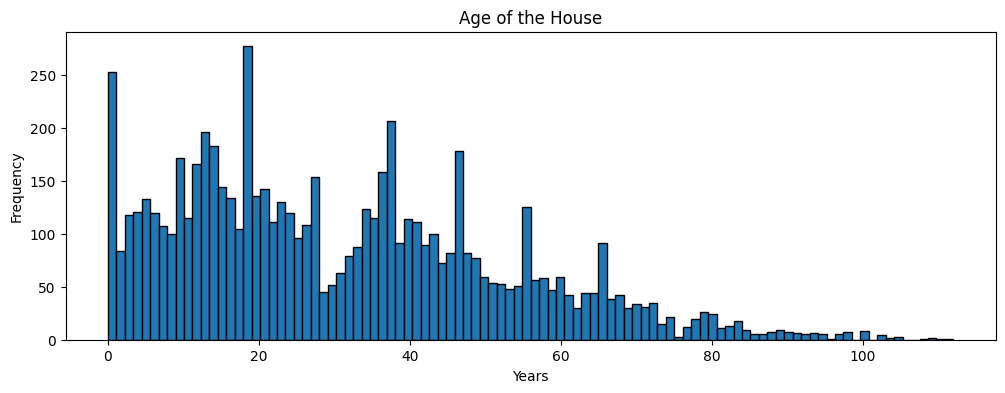

In [26]:
plt.figure(figsize=(12, 4))
plt.hist(df_features['house_age'], bins=100, edgecolor='black')
plt.title('Age of the House')
plt.xlabel('Years')
plt.ylabel('Frequency')
plt.show()

In [27]:
# Create age categories based on your data distribution
# Using quartiles and real estate market understanding
df_features['age_category'] = 'Very Old'  # Default (>45 years, top 25%)

# New construction (0-5 years)
df_features.loc[df_features['house_age'] <= 5, 'age_category'] = 'New'

# Modern (6-14 years) - up to 25th percentile 
df_features.loc[(df_features['house_age'] > 5) & (df_features['house_age'] <= 14), 'age_category'] = 'Modern'

# Established (15-27 years) - 25th to 50th percentile
df_features.loc[(df_features['house_age'] > 14) & (df_features['house_age'] <= 27), 'age_category'] = 'Established'

# Mature (28-45 years) - 50th to 75th percentile  
df_features.loc[(df_features['house_age'] > 27) & (df_features['house_age'] <= 45), 'age_category'] = 'Mature'

# Very Old (>45 years) - top 25% - already set as default

print("Age Categories:")
print(df_features['age_category'].value_counts())

# Count luxury features -- maybe Garage is not a luxury, can remove later!
luxury_features = ['hasSpa', 'hasView', 'hasGarage']
df_features['luxury_score'] = df_features[luxury_features].sum(axis=1)

Age Categories:
Very Old       1670
Mature         1653
Established    1593
Modern         1159
New             709
Name: age_category, dtype: int64


Age ranges:
- **New:** 0-5 years
- **Modern:** 6-14 years
- **Established:** 15-27 years
- **Mature:** 28-45 years
- **Very Old:** 46+ years

In [28]:
# Old house with many bedrooms
# Old houses (built before 1980) with many bedrooms (4+) might have layout issues which affect the price
df_features['old_house_many_beds'] = (
    (df_features['yearBuilt'] <= 1980) & 
    (df_features['numOfBedrooms'] >= 4)
).astype(int)

old_many_beds = df_features['old_house_many_beds'].sum()
print(f"   Found {old_many_beds} old houses (≤1980) with 4+ bedrooms")

   Found 635 old houses (≤1980) with 4+ bedrooms


### 3. CREATE AMENITY FEATURES


In [29]:
# Count all the "numOf" feature columns
amenity_cols = [col for col in df_features.columns if col.startswith('numOf') and 'Features' in col]
print(f"Found amenity columns: {amenity_cols}")

Found amenity columns: ['numOfAccessibilityFeatures', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures', 'numOfWaterfrontFeatures', 'numOfWindowFeatures', 'numOfCommunityFeatures']


In [30]:
df_features['total_amenities'] = df_features[amenity_cols].sum(axis=1)

In [31]:
# Count luxury features -- maybe Garage is not a luxury, can remove later!
luxury_features = ['hasSpa', 'hasView', 'hasGarage']
df_features['luxury_score'] = df_features[luxury_features].sum(axis=1)

### 4. LOCATION-BASED FEATURES

In [32]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate great circle distance between two points on Earth (decimal degrees)
    Returns distance in miles
    """
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = (math.sin(dlat / 2) ** 2 +
         math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2)
    
    c = 2 * math.asin(math.sqrt(a))
    r = 3959  # Radius of Earth in miles
    
    return c * r

- **DISTANCE TO DOWNTOWN AUSTIN**

In [33]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [34]:
from haversine import haversine

In [35]:
# Austin coordinates
downtown_austin_lat = 30.2672
downtown_austin_lon = -97.7431
airport_lat = 30.1975
airport_lon = -97.6664
ut_lat = 30.2849
ut_lon = -97.7341

# Calculate all distances using the same function
df_features['dist_to_downtown'] = df_features.apply(
    lambda row: haversine_distance(row['latitude'], row['longitude'], 
                                 downtown_austin_lat, downtown_austin_lon), axis=1
)

df_features['distanceToCenter'] = df_features.apply(
    lambda row: haversine_distance(row['latitude'], row['longitude'], 
                                 downtown_austin_lat, downtown_austin_lon), axis=1
)

df_features['dist_to_airport'] = df_features.apply(
    lambda row: haversine_distance(row['latitude'], row['longitude'], 
                                 airport_lat, airport_lon), axis=1
)

df_features['dist_to_ut'] = df_features.apply(
    lambda row: haversine_distance(row['latitude'], row['longitude'], 
                                 ut_lat, ut_lon), axis=1
)

print(f"Distance to downtown - Mean: {df_features['dist_to_downtown'].mean():.2f} miles, Max: {df_features['dist_to_downtown'].max():.2f}")
print(f"Distance to airport - Mean: {df_features['dist_to_airport'].mean():.2f} miles, Max: {df_features['dist_to_airport'].max():.2f}")
print(f"Distance to UT - Mean: {df_features['dist_to_ut'].mean():.2f} miles, Max: {df_features['dist_to_ut'].max():.2f}")

Distance to downtown - Mean: 8.07 miles, Max: 17.27
Distance to airport - Mean: 11.70 miles, Max: 22.57
Distance to UT - Mean: 8.06 miles, Max: 18.11


In [36]:
print(f"\nLocation feature correlations with price:")
location_price_corr = df_features[['dist_to_downtown', 'dist_to_ut', 'dist_to_airport', 
                                  'latestPrice']].corr()['latestPrice'].sort_values()

for feature, corr in location_price_corr.items():
    if feature != 'latestPrice':
        print(f"  {feature}: {corr:.3f}")


Location feature correlations with price:
  dist_to_ut: -0.229
  dist_to_downtown: -0.222
  dist_to_airport: 0.039


- **CARDINAL DIRECTION FROM DOWNTOWN**

In [37]:
def get_direction_from_downtown(lat, lon):
    """Get cardinal direction from downtown Austin"""
    lat_diff = lat - downtown_austin_lat
    lon_diff = lon - downtown_austin_lon
    
    # Calculate angle in degrees
    angle = math.degrees(math.atan2(lat_diff, lon_diff))
    
    # Convert to cardinal directions
    if -22.5 <= angle < 22.5:
        return "East"
    elif 22.5 <= angle < 67.5:
        return "Northeast"
    elif 67.5 <= angle < 112.5:
        return "North"
    elif 112.5 <= angle < 157.5:
        return "Northwest"
    elif 157.5 <= angle or angle < -157.5:
        return "West"
    elif -157.5 <= angle < -112.5:
        return "Southwest"
    elif -112.5 <= angle < -67.5:
        return "South"
    else:  # -67.5 <= angle < -22.5
        return "Southeast"

df_features['direction_from_downtown'] = df_features.apply(
    lambda row: get_direction_from_downtown(row['latitude'], row['longitude']) 
    if not pd.isna(row['latitude']) else 'Unknown', axis=1
)

print("Direction distribution:")
print(df_features['direction_from_downtown'].value_counts())


Direction distribution:
Southwest    1794
North        1770
Northeast     830
Northwest     673
West          670
South         473
East          420
Southeast     154
Name: direction_from_downtown, dtype: int64


- **CREATE LOCATION CONVENIENCE SCORE**

In [38]:
# Closer to downtown/UT = higher score, closer to airport = medium score
# Normalize distances to 0-1 scale and invert (closer = higher score)
max_downtown_dist = df_features['dist_to_downtown'].max()
max_ut_dist = df_features['dist_to_ut'].max()
max_airport_dist = df_features['dist_to_airport'].max()

df_features['downtown_score'] = 1 - (df_features['dist_to_downtown'] / max_downtown_dist)
df_features['airport_score'] = 1 - (df_features['dist_to_airport'] / max_airport_dist)


- **Geographic Density Outlier**

In [39]:
# Create lat/lon bins and count houses in each
df_features['lat_bin'] = pd.cut(df_features['latitude'], bins=20, labels=False)
df_features['lon_bin'] = pd.cut(df_features['longitude'], bins=20, labels=False)

# Count houses in same geographic bin
df_features['geo_bin'] = df_features['lat_bin'].astype(str) + '_' + df_features['lon_bin'].astype(str)
geo_bin_counts = df_features['geo_bin'].value_counts()
df_features['houses_in_geo_area'] = df_features['geo_bin'].map(geo_bin_counts)

# Flag houses in very sparse areas (potential data quality issues)
df_features['is_isolated_location'] = (df_features['houses_in_geo_area'] <= 2).astype(int)

isolated_count = df_features['is_isolated_location'].sum()
print(f"   Found {isolated_count} houses in isolated locations (≤2 houses nearby)")

   Found 33 houses in isolated locations (≤2 houses nearby)


- **Distance - Size Interaction**

In [40]:
# Small houses far from downtown might be problematic
df_features['small_house_far_downtown'] = (
    (df_features['livingAreaSqFt'] <= 1500) & 
    (df_features['dist_to_downtown'] >= 10.0)
).astype(int)

# Large houses very close to downtown
df_features['large_house_close_downtown'] = (
    (df_features['livingAreaSqFt'] >= 4000) & 
    (df_features['dist_to_downtown'] <= 3.0)
).astype(int)

small_far = df_features['small_house_far_downtown'].sum()
large_close = df_features['large_house_close_downtown'].sum()
print(f"   Small houses far from downtown: {small_far}")
print(f"   Large houses close to downtown: {large_close}")

   Small houses far from downtown: 155
   Large houses close to downtown: 20


- **Bathroom - Bedroom Ratio**

In [41]:
# Very low ratio (not enough bathrooms) or very high ratio (too many bathrooms)
ratio_q10 = df_features['bath_bed_ratio'].quantile(0.10)
ratio_q90 = df_features['bath_bed_ratio'].quantile(0.90)

df_features['extreme_bath_bed_ratio'] = (
(df_features['bath_bed_ratio'] <= ratio_q10) | 
(df_features['bath_bed_ratio'] >= ratio_q90)
).astype(int)

extreme_ratio = df_features['extreme_bath_bed_ratio'].sum()
print(f"   Houses with extreme bath-bed ratios: {extreme_ratio}")

   Houses with extreme bath-bed ratios: 1798


- **Very old/Very new built**

In [42]:
# Very old houses (bottom 5%) or very new houses (top 5%) might be special
year_bottom_5 = df_features['yearBuilt'].quantile(0.05)
year_top_95 = df_features['yearBuilt'].quantile(0.95)

df_features['is_very_old_house'] = (df_features['yearBuilt'] <= year_bottom_5).astype(int)
df_features['is_very_new_house'] = (df_features['yearBuilt'] >= year_top_95).astype(int)

very_old = df_features['is_very_old_house'].sum()
very_new = df_features['is_very_new_house'].sum()
print(f"   Very old houses (≤{year_bottom_5:.0f}): {very_old}")
print(f"   Very new houses (≥{year_top_95:.0f}): {very_new}")

   Very old houses (≤1949): 352
   Very new houses (≥2017): 351


In [43]:
df_features['latestPrice'].corr(df_features['is_very_new_house'])

0.19690716245983195

- **From your residual analysis: very large houses (5000+ sqft) also have high residuals**


In [44]:
# Top 5% of house sizes
size_top_5pct = df_features['livingAreaSqFt'].quantile(0.95)
df_features['is_very_large_house'] = (df_features['livingAreaSqFt'] >= size_top_5pct).astype(int)

large_house_count = df_features['is_very_large_house'].sum()
print(f"   Found {large_house_count} very large houses (≥{size_top_5pct:.0f} sqft)")

# Also flag extreme outliers (top 1%)
size_top_1pct = df_features['livingAreaSqFt'].quantile(0.99)
df_features['is_mansion_size'] = (df_features['livingAreaSqFt'] >= size_top_1pct).astype(int)

mansion_count = df_features['is_mansion_size'].sum()
print(f"   Found {mansion_count} mansion-sized houses (≥{size_top_1pct:.0f} sqft)")

   Found 341 very large houses (≥3818 sqft)
   Found 68 mansion-sized houses (≥4880 sqft)


- **Very recent construction**

In [45]:
# very recent houses (2010+) have high residuals
# Houses built in last 15 years
current_year = 2025
df_features['is_recently_built'] = (df_features['yearBuilt'] >= 2010).astype(int)

# Houses built in last 5 years (very new)
df_features['is_brand_new'] = (df_features['yearBuilt'] >= 2020).astype(int)

recent_count = df_features['is_recently_built'].sum()
brand_new_count = df_features['is_brand_new'].sum()
print(f"   Recently built houses (≥2010): {recent_count}")
print(f"   Brand new houses (≥2020): {brand_new_count}")

   Recently built houses (≥2010): 1109
   Brand new houses (≥2020): 72


- **Size extreme flags!**

In [46]:
# Both very small AND very large houses seem problematic
size_bottom_5pct = df_features['livingAreaSqFt'].quantile(0.05)
size_top_5pct = df_features['livingAreaSqFt'].quantile(0.95)

df_features['is_extreme_size'] = (
    (df_features['livingAreaSqFt'] <= size_bottom_5pct) |
    (df_features['livingAreaSqFt'] >= size_top_5pct)
).astype(int)

extreme_size_count = df_features['is_extreme_size'].sum()
print(f"   Houses with extreme sizes (very small OR very large): {extreme_size_count}")

   Houses with extreme sizes (very small OR very large): 682


- **New, Large houses!** 

In [47]:
# New, large houses might be especially problematic
df_features['new_large_house'] = (
(df_features['yearBuilt'] >= 2010) &
(df_features['livingAreaSqFt'] >= 4000)
).astype(int)

new_large_count = df_features['new_large_house'].sum()
print(f"   New large houses (≥2010 & ≥4000 sqft): {new_large_count}")

   New large houses (≥2010 & ≥4000 sqft): 70


### 5. SCHOOL-RELATED FEATURES

In [48]:
# Create school rating categories (more interpretable than normalization)
df_features['school_tier'] = 'Average'  # Default
df_features.loc[df_features['avgSchoolRating'] <= 4.0, 'school_tier'] = 'Below Average'  # Bottom 25%
df_features.loc[df_features['avgSchoolRating'] >= 7.0, 'school_tier'] = 'Above Average'  # Top 25%
df_features.loc[df_features['avgSchoolRating'] >= 8.5, 'school_tier'] = 'Excellent'     # Top schools

print(df_features['school_tier'].value_counts())

Average          2556
Below Average    1886
Above Average    1689
Excellent         653
Name: school_tier, dtype: int64


In [49]:
# Teacher-student ratio: lower is better
# Create a simple "teacher attention" score (invert the ratio)
# Higher score = more teacher attention (lower student-teacher ratio)
max_ratio = df_features['MedianStudentsPerTeacher'].max()
df_features['teacher_attention_score'] = max_ratio - df_features['MedianStudentsPerTeacher']

### 6. SIZE CATEGORIES

In [50]:
print(f"Living area distribution:")
print(df_features['livingAreaSqFt'].describe())

# Create size categories based on your quartiles and market reality
df_features['size_category'] = 'Large'  # Default for >75th percentile

# Small: Up to 25th percentile (≤1496 sqft)
df_features.loc[df_features['livingAreaSqFt'] <= 1496, 'size_category'] = 'Small'

# Medium: 25th to 75th percentile (1497-2645 sqft) 
df_features.loc[(df_features['livingAreaSqFt'] > 1496) & 
                (df_features['livingAreaSqFt'] <= 2645), 'size_category'] = 'Medium'

# Large: Above 75th percentile (>2645 sqft) - already set as default

# Extra Large: Top 5% (very large homes)
top_95_percentile = df_features['livingAreaSqFt'].quantile(0.95)
df_features.loc[df_features['livingAreaSqFt'] > top_95_percentile, 'size_category'] = 'Extra Large'

print("Size Category")
print(df_features['size_category'].value_counts())


Living area distribution:
count    6784.000000
mean     2157.235554
std       891.719162
min       306.000000
25%      1496.000000
50%      1992.000000
75%      2645.000000
max      8647.000000
Name: livingAreaSqFt, dtype: float64
Size Category
Medium         3389
Small          1701
Large          1355
Extra Large     339
Name: size_category, dtype: int64


Size ranges:
- Small: ≤1,496 sqft (bottom 25%)
- Medium: 1,497-2,645 sqft (middle 50%)
- Large: 2,646-{top_95_percentile:.0f} sqft (75th-95th percentile)
- Extra Large: >{top_95_percentile:.0f} sqft (top 5%)


### TEXT MINING FROM PROPERTY DESCRIPTIONS

In [51]:
df_text = df.copy()
# Fill missing descriptions
df_text['description'] = df_text['description'].fillna('')
df_text['description_clean'] = df_text['description'].str.lower()

In [52]:
# ================================================================
# PHASE 1: BASIC TEXT MINING (KEYWORD EXTRACTION)
# ================================================================

In [53]:
# LUXURY KEYWORDS
luxury_keywords = [
    'granite', 'quartz', 'marble', 'hardwood', 'upgraded', 'custom', 'luxury',
    'premium', 'high-end', 'stainless', 'gourmet', 'spa', 'pool', 'fireplace',
    'crown molding', 'coffered', 'vaulted', 'cathedral', 'master suite',
    'walk-in closet', 'double vanity', 'jetted tub', 'steam shower'
]

luxury_count = 0
for keyword in luxury_keywords:
    df_text[f'has_{keyword.replace(" ", "_").replace("-", "_")}'] = df_text['description_clean'].str.contains(keyword, na=False).astype(int)
    count = df_text[f'has_{keyword.replace(" ", "_").replace("-", "_")}'].sum()
    if count > 0:
        luxury_count += 1

luxury_cols = [col for col in df_text.columns if col.startswith('has_') and any(kw.replace(" ", "_").replace("-", "_") in col for kw in luxury_keywords)]
df_text['description_luxury_score'] = df_text[luxury_cols].sum(axis=1)

print(f"Created {len(luxury_cols)} luxury keyword features")

Created 23 luxury keyword features


In [54]:
# CONDITION KEYWORDS
condition_keywords = {
    'excellent': ['move-in ready', 'pristine', 'immaculate', 'stunning', 'gorgeous', 'beautiful'],
    'updated': ['renovated', 'remodeled', 'updated', 'new flooring', 'fresh paint', 'recent'],
    'issues': ['needs work', 'fixer', 'as-is', 'handyman', 'tlc', 'potential']
}

for condition, keywords in condition_keywords.items():
    df_text[f'condition_{condition}'] = 0
    for keyword in keywords:
        df_text[f'condition_{condition}'] += df_text['description_clean'].str.contains(keyword, na=False).astype(int)
    df_text[f'condition_{condition}'] = (df_text[f'condition_{condition}'] > 0).astype(int)

In [55]:
#  DESCRIPTION QUALITY
df_text['description_length'] = df_text['description'].str.len()
df_text['description_word_count'] = df_text['description'].str.split().str.len()
df_text['description_exclamation_count'] = df_text['description'].str.count('!')


In [56]:
# LOCATION MENTIONS
location_keywords = [
    'downtown', 'airport', 'shopping', 'school', 'park', 'trail', 'lake',
    'river', 'highway', 'toll', 'minutes to', 'close to', 'walking distance'
]

for keyword in location_keywords:
    df_text[f'near_{keyword.replace(" ", "_")}'] = df_text['description_clean'].str.contains(keyword, na=False).astype(int)

location_cols = [col for col in df_text.columns if col.startswith('near_')]
df_text['description_location_score'] = df_text[location_cols].sum(axis=1)



In [57]:
# 6. SPECIFIC HIGH-VALUE FEATURES
specific_features = {
    'pool_mentioned': ['pool', 'swimming'],
    'garage_mentioned': ['garage', 'car garage', 'parking'],
    'kitchen_quality': ['gourmet kitchen', 'chef kitchen', 'island', 'breakfast bar'],
    'master_luxury': ['master suite', 'master bedroom', 'en-suite', 'walk-in shower']
}
for feature, keywords in specific_features.items():
    df_text[feature] = 0
    for keyword in keywords:
        df_text[feature] += df_text['description_clean'].str.contains(keyword, na=False).astype(int)
    df_text[feature] = (df_text[feature] > 0).astype(int)


In [58]:
# BASIC TEXT FEATURES SUMMARY
basic_text_features = []
basic_text_features.extend(luxury_cols)
basic_text_features.extend([f'condition_{c}' for c in condition_keywords.keys()])
# basic_text_features.extend(outdoor_cols)
basic_text_features.extend(location_cols)
basic_text_features.extend(['description_length', 'description_word_count', 'description_exclamation_count', 'description_caps_ratio'])
basic_text_features.extend(['description_luxury_score', 'description_outdoor_score', 'description_location_score'])
basic_text_features.extend(list(specific_features.keys()))

print(f"\nPhase 1 Summary: Created {len(basic_text_features)} basic text features")



Phase 1 Summary: Created 50 basic text features


In [59]:
# ================================================================
# PHASE 2: ADVANCED NLP
# ================================================================

In [60]:
# Advanced text preprocessing

def advanced_text_preprocessing(text):
    text = text.lower()
    text = re.sub(r'[^\w\s\-]', ' ', text)
    text = ' '.join(text.split())
    words = [word for word in text.split() if len(word) >= 3]
    return ' '.join(words)

descriptions_clean_advanced = df_text['description'].apply(advanced_text_preprocessing)

In [61]:
#  TF-IDF FEATURES

# Unigram TF-IDF
tfidf_unigram = TfidfVectorizer(
    max_features=50,   # Reduced to avoid overfitting
    min_df=5,
    max_df=0.8,
    ngram_range=(1,1),
    stop_words='english'
)

tfidf_unigram_matrix = tfidf_unigram.fit_transform(descriptions_clean_advanced)

# Bigram TF-IDF
tfidf_bigram = TfidfVectorizer(
    max_features=25,   # Smaller for bigrams
    min_df=3,
    max_df=0.7,
    ngram_range=(2,2),
    stop_words='english'
)
tfidf_bigram_matrix = tfidf_bigram.fit_transform(descriptions_clean_advanced)

print(f"Created {tfidf_unigram_matrix.shape[1]} unigram and {tfidf_bigram_matrix.shape[1]} bigram TF-IDF features")

Created 50 unigram and 25 bigram TF-IDF features


In [62]:
#  DIMENSIONALITY REDUCTION

# Reduce TF-IDF to manageable dimensions
n_components_uni = min(15, tfidf_unigram_matrix.shape[1])
n_components_bi = min(10, tfidf_bigram_matrix.shape[1])

if n_components_uni > 1:
    svd_unigram = TruncatedSVD(n_components=n_components_uni, random_state=42)
    tfidf_unigram_reduced = svd_unigram.fit_transform(tfidf_unigram_matrix)
    
    for i in range(n_components_uni):
        df_text[f'tfidf_unigram_svd_{i}'] = tfidf_unigram_reduced[:, i]

if n_components_bi > 1:
    svd_bigram = TruncatedSVD(n_components=n_components_bi, random_state=42)
    tfidf_bigram_reduced = svd_bigram.fit_transform(tfidf_bigram_matrix)
    
    for i in range(n_components_bi):
        df_text[f'tfidf_bigram_svd_{i}'] = tfidf_bigram_reduced[:, i]

In [63]:
#  REAL ESTATE PHRASE PATTERNS

real_estate_phrases = [
    (r'move[\s\-]*in[\s\-]*ready', 'move_in_ready'),
    (r'recently[\s\-]*updated', 'recently_updated'),
    (r'granite[\s\-]*counter', 'granite_counter'),
    (r'hardwood[\s\-]*floor', 'hardwood_floor'),
    (r'stainless[\s\-]*steel', 'stainless_steel'),
    (r'open[\s\-]*floor[\s\-]*plan', 'open_floor_plan'),
    (r'master[\s\-]*suite', 'master_suite_phrase'),
    (r'walk[\s\-]*in[\s\-]*closet', 'walk_in_closet'),
    (r'covered[\s\-]*patio', 'covered_patio'),
    (r'fenced[\s\-]*yard', 'fenced_yard'),
    (r'corner[\s\-]*lot', 'corner_lot'),
    (r'cul[\s\-]*de[\s\-]*sac', 'cul_de_sac')
]

for phrase_pattern, phrase_name in real_estate_phrases:
    df_text[f'phrase_{phrase_name}'] = descriptions_clean_advanced.str.contains(phrase_pattern, regex=True, na=False).astype(int)


In [64]:
#  SIMPLE TEXT EMBEDDINGS

def create_simple_embeddings(descriptions, vocab_size=20):
    vectorizer = CountVectorizer(max_features=vocab_size, stop_words='english', min_df=3)
    word_matrix = vectorizer.fit_transform(descriptions)
    
    vocab = vectorizer.get_feature_names_out()
    doc_freq = np.array(word_matrix.sum(axis=0)).flatten()
    idf = np.log(len(descriptions) / (doc_freq + 1))
    
    embeddings = np.zeros((len(descriptions), vocab_size))
    
    for i, desc in enumerate(descriptions):
        words = desc.split()
        for word in words:
            if word in vocab:
                word_idx = list(vocab).index(word)
                embeddings[i, word_idx] += idf[word_idx]
    
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    embeddings = embeddings / (norms + 1e-8)
    
    return embeddings

embeddings = create_simple_embeddings(descriptions_clean_advanced, vocab_size=15)

for i in range(embeddings.shape[1]):
    df_text[f'text_embedding_{i}'] = embeddings[:, i]

In [65]:
# 2.6 SENTIMENT AND STYLE

positive_words = ['beautiful', 'stunning', 'gorgeous', 'amazing', 'perfect', 'excellent', 'fantastic', 'wonderful']
negative_words = ['needs', 'fixer', 'repair', 'tlc', 'work', 'older', 'dated']

df_text['positive_sentiment_count'] = sum(descriptions_clean_advanced.str.count(word) for word in positive_words)
df_text['negative_sentiment_count'] = sum(descriptions_clean_advanced.str.count(word) for word in negative_words)
df_text['sentiment_ratio'] = (df_text['positive_sentiment_count'] + 1) / (df_text['negative_sentiment_count'] + 1)

# Marketing style
df_text['caps_words_count'] = df_text['description'].str.count(r'\b[A-Z]{2,}\b')
df_text['exclamation_density'] = df_text['description'].str.count('!') / (df_text['description_length'] + 1)


In [66]:
# ADVANCED TEXT FEATURES SUMMARY
advanced_text_features = []
advanced_text_features.extend([f'tfidf_unigram_svd_{i}' for i in range(n_components_uni)])
advanced_text_features.extend([f'tfidf_bigram_svd_{i}' for i in range(n_components_bi)])
advanced_text_features.extend([f'phrase_{name}' for _, name in real_estate_phrases])
advanced_text_features.extend([f'text_embedding_{i}' for i in range(embeddings.shape[1])])
advanced_text_features.extend(['positive_sentiment_count', 'negative_sentiment_count', 'sentiment_ratio', 'caps_words_count', 'exclamation_density'])

print(f"\nPhase 2 Summary: Created {len(advanced_text_features)} advanced NLP features")


Phase 2 Summary: Created 57 advanced NLP features


In [67]:
# ================================================================
# PHASE 3: CORRELATION FILTERING AND INTEGRATION
# ================================================================

In [68]:
# Combine all text features
all_text_features = basic_text_features + advanced_text_features

# Filter features that actually exist
existing_text_features = [f for f in all_text_features if f in df_text.columns]

print(f"Total text features created: {len(existing_text_features)}")


Total text features created: 105


In [69]:
# Calculate correlations with target variable

text_correlations = {}
for feature in existing_text_features:
    corr = df_text[feature].corr(df_text['latestPrice'])
    if not pd.isna(corr):
        text_correlations[feature] = corr
        
# Sort by absolute correlation
sorted_correlations = sorted(text_correlations.items(), key=lambda x: abs(x[1]), reverse=True)

print(f"Top 20 text features by correlation:")
for feature, corr in sorted_correlations[:20]:
    print(f"  {feature[:45]:<45}: {corr:>7.4f}")

Top 20 text features by correlation:
  near_lake                                    :  0.1834
  has_custom                                   :  0.1671
  pool_mentioned                               :  0.1433
  has_pool                                     :  0.1402
  description_length                           :  0.1393
  description_word_count                       :  0.1306
  has_gourmet                                  :  0.1292
  description_luxury_score                     :  0.1262
  tfidf_unigram_svd_6                          : -0.1212
  has_marble                                   :  0.1120
  tfidf_unigram_svd_2                          : -0.1109
  tfidf_bigram_svd_4                           :  0.1045
  has_luxury                                   :  0.1025
  sentiment_ratio                              :  0.1022
  has_spa                                      :  0.0947
  kitchen_quality                              :  0.0928
  positive_sentiment_count                     :  0

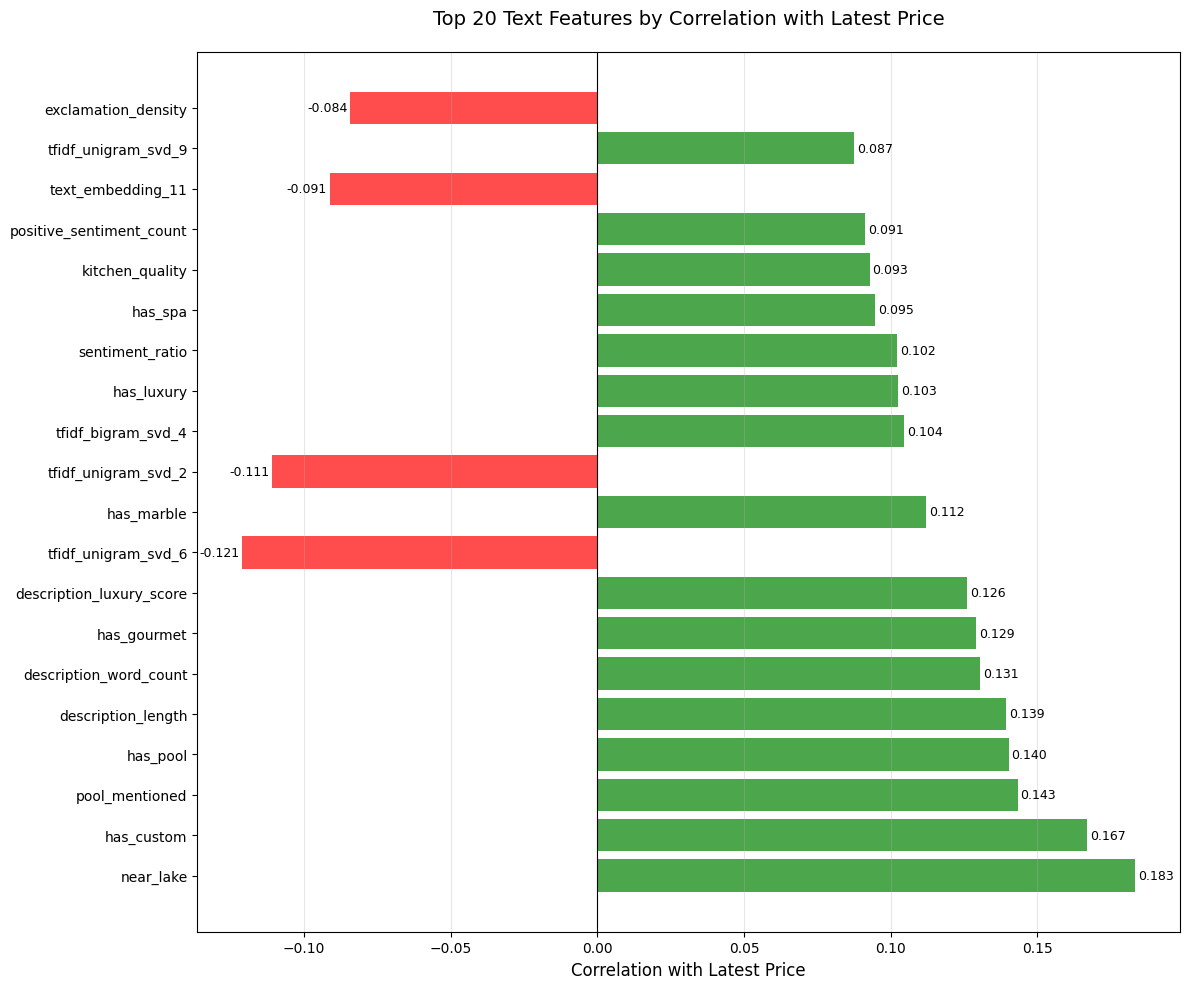

In [70]:
# Create visualization
top_20 = sorted_correlations[:20]
features = [item[0] for item in top_20]
correlations = [item[1] for item in top_20]

# Create horizontal bar plot
plt.figure(figsize=(12, 10))
colors = ['red' if corr < 0 else 'green' for corr in correlations]

bars = plt.barh(range(len(features)), correlations, color=colors, alpha=0.7)

# Customize the plot
plt.yticks(range(len(features)), [f[:40] + '...' if len(f) > 40 else f for f in features])
plt.xlabel('Correlation with Latest Price', fontsize=12)
plt.title('Top 20 Text Features by Correlation with Latest Price', fontsize=14, pad=20)
plt.grid(axis='x', alpha=0.3)

# Add correlation values on the bars
for i, (bar, corr) in enumerate(zip(bars, correlations)):
    plt.text(corr + (0.001 if corr >= 0 else -0.001), i, f'{corr:.3f}', 
             va='center', ha='left' if corr >= 0 else 'right', fontsize=9)

# Add vertical line at x=0
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.show()

In [71]:
#  FILTER FEATURES BY CORRELATION THRESHOLD

correlation_threshold = 0.05 
good_text_features = [feature for feature, corr in text_correlations.items() if abs(corr) >= correlation_threshold]

print(f"Features with |correlation| >= {correlation_threshold}: {len(good_text_features)}")

# 3.3 COMBINE WITH MAIN DATASET

# Add good text features to main dataset
for feature in good_text_features:
    df_features[feature] = df_text[feature]

print(f"Added {len(good_text_features)} high-correlation text features to main dataset")


Features with |correlation| >= 0.05: 40
Added 40 high-correlation text features to main dataset


### 7. ENCODE CATEGORICAL VARIABLES

In [72]:
categorical_encode = ['age_category', 'size_category', 'direction_from_downtown', 'school_tier']

for cat_col in categorical_encode:
    if cat_col in df_features.columns:
        dummies = pd.get_dummies(df_features[cat_col], prefix=cat_col)
        df_features = pd.concat([df_features, dummies], axis=1)


In [73]:
le_zip = LabelEncoder()
df_features['zipcode_encoded'] = le_zip.fit_transform(df_features['zipcode'].astype(str))
df_features = df_features.drop('zipcode', axis=1)

In [74]:
new_numeric_features = [
    'lot_to_living_ratio', 'bath_bed_ratio', 'house_age',
    'total_amenities', 'luxury_score', 'school_quality_score','room_density','lotSize_bathrooms'
]

print(f"Original features: {df_clean.shape[1]}")
print(f"After feature engineering: {df_features.shape[1]}")
print(f"New features added: {df_features.shape[1] - df_clean.shape[1]}")

Original features: 32
After feature engineering: 131
New features added: 99


In [75]:
# Check for any infinite or NaN values in new features
print(f"\nChecking for infinite values: {np.isinf(df_features.select_dtypes(include=[np.number])).sum().sum()}")
print(f"Checking for NaN values: {df_features.isnull().sum().sum()}")



Checking for infinite values: 0
Checking for NaN values: 0


## Ready for modeling!

### PREPARE DATA FOR MODELING

### 1. SELECT FEATURES FOR MODELING

In [76]:
print(f"Total columns available: {len(df_features.columns)}")
print("All columns:", df_features.columns.tolist())

Total columns available: 131
All columns: ['latitude', 'longitude', 'propertyTaxRate', 'garageSpaces', 'hasAssociation', 'hasGarage', 'hasSpa', 'hasView', 'yearBuilt', 'latestPrice', 'latest_saledate', 'latest_salemonth', 'latest_saleyear', 'numOfPhotos', 'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures', 'numOfWaterfrontFeatures', 'numOfWindowFeatures', 'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms', 'numOfBedrooms', 'numOfStories', 'sqft_per_bedroom', 'is_cramped_layout', 'lot_to_living_ratio', 'bath_bed_ratio', 'room_density', 'is_very_small_house', 'lotSize_bathrooms', 'house_age', 'age_category', 'luxury_score', 'old_house_many_beds', 'total_amenities', 'dist_to_downtown', 'distanceToCenter', 'dist_to_airport', 'dist_to_ut', 'direction_from_downtown', 'downtown_score', 'airport_score', 'lat_bi

In [77]:
# Define target variable
target = 'latestPrice'

In [78]:
exclude_cols = [
    'latestPrice',  # Target
    'latest_saledate', 'latest_salemonth', 'latest_saleyear',
    'streetAddress', 'description', 'description_clean',
    'homeType', 'age_category', 'zipcode_tier', 'size_category', 'school_tier','geo_bin',
    'direction_from_downtown',  # Keep this as categorical exclude
    'zipcode'
]

# Remove columns that exist
exclude_cols = [col for col in exclude_cols if col in df_features.columns]

# Create feature matrix
X_clean = df_features.drop(columns=exclude_cols)


In [79]:
#X_clean.to_csv('/Users/apple/Desktop/R-ML/to_test_1.csv', index=False)

In [80]:
# 4. ENSURE PROPER DATA TYPES

# Convert to float64 (for XGBoost)
X_clean = X_clean.astype('float64')

# Get target variable -- taking log prices!
y_clean = df_features['latestPrice'].astype('float64')

In [81]:
y_clean

0       687.850
1       409.000
2       199.000
3       400.000
4       240.000
         ...   
6779    647.877
6780    445.000
6781    400.000
6782    550.000
6783    875.000
Name: latestPrice, Length: 6784, dtype: float64

In [82]:
# CV setup
cv_folds = 5
kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Model results storage
cv_results = {}

def evaluate_model_cv(name, model, X, y):
    """Evaluate model with cross-validation"""
    print(f"Evaluating {name}...")
    
    mse_scores = cross_val_score(model, X, y, cv=kfold, 
                                scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-mse_scores)
    
    rmse_mean = rmse_scores.mean()
    rmse_std = rmse_scores.std()
    
    cv_results[name] = {
        'rmse_mean': rmse_mean,
        'rmse_std': rmse_std,
        'rmse_scores': rmse_scores
    }
    
    print(f"  RMSE: ${rmse_mean:,.0f} ± ${rmse_std:,.0f}")
    return rmse_mean


In [83]:
# # CV setup
# cv_folds = 5
# kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
# # Model results storage
# cv_results = {}

# def evaluate_model_cv(name, model, X, y):
#     """Evaluate model with cross-validation - converts log predictions back to original scale"""
#     print(f"Evaluating {name}...")
    
#     # Get predictions for each fold to calculate RMSE in original scale
#     original_rmse_scores = []
    
#     for train_idx, val_idx in kfold.split(X):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
#         # Fit model and predict in log space
#         model_copy = clone(model)
#         model_copy.fit(X_train, y_train)
#         y_pred_log = model_copy.predict(X_val)
        
#         # Convert back to original scale (simple exp for log(price))
#         y_val_original = np.exp(y_val)
#         y_pred_original = np.exp(y_pred_log)
        
#         # Calculate RMSE in original scale
#         rmse_original = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
#         original_rmse_scores.append(rmse_original)
    
#     original_rmse_scores = np.array(original_rmse_scores)
#     rmse_mean = original_rmse_scores.mean()
#     rmse_std = original_rmse_scores.std()
    
#     cv_results[name] = {
#         'rmse_mean': rmse_mean,
#         'rmse_std': rmse_std,
#         'rmse_scores': original_rmse_scores
#     }
    
#     print(f"  RMSE: ${rmse_mean:,.0f} ± ${rmse_std:,.0f}")
#     return rmse_mean



In [84]:
# 1. OPTIMIZED RANDOM FOREST
rf_optimized = RandomForestRegressor(
    n_estimators=500,          # More trees
    max_depth=20,              # Deeper trees
    min_samples_split=2,       # Allow more splits
    min_samples_leaf=1,        # Smallest leaves
    max_features='sqrt',       # Feature sampling
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
rf_rmse = evaluate_model_cv('Random Forest Optimized', rf_optimized, X_clean, y_clean)

Evaluating Random Forest Optimized...
  RMSE: $163 ± $28


In [85]:
# 2. EXTRA TREES (OFTEN BETTER THAN RF)
et_optimized = ExtraTreesRegressor(
    n_estimators=500,
    max_depth=25,              # Even deeper
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=False,           # Extra Trees uses all data
    random_state=42,
    n_jobs=-1
)
et_rmse = evaluate_model_cv('Extra Trees Optimized', et_optimized, X_clean, y_clean)

Evaluating Extra Trees Optimized...
  RMSE: $167 ± $28


In [86]:
# 3. GRADIENT BOOSTING (TUNED)
gb_optimized = GradientBoostingRegressor(
    n_estimators=400,          # More estimators
    max_depth=8,               # Deeper trees
    learning_rate=0.08,        # Slightly slower learning
    subsample=0.85,            # More data per tree
    min_samples_split=3,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)
gb_rmse = evaluate_model_cv('Gradient Boosting Tuned', gb_optimized, X_clean, y_clean)


Evaluating Gradient Boosting Tuned...
  RMSE: $166 ± $25


In [87]:
# 5. ADVANCED GRADIENT BOOSTING 
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.08,
    subsample=0.85,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)
xgb_rmse = evaluate_model_cv('XGBoost Optimized', xgb_model, X_clean, y_clean)

xgb_rmse = float('inf')


Evaluating XGBoost Optimized...
  RMSE: $172 ± $25


In [88]:
# 6. LightGBM

lgb_model = lgb.LGBMRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.08,
    subsample=0.85,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_rmse = evaluate_model_cv('LightGBM Optimized', lgb_model, X_clean, y_clean)

lgb_rmse = float('inf')

Evaluating LightGBM Optimized...
  RMSE: $163 ± $27


In [89]:
#7. Catboost
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    iterations=2000,
    depth=8,
    learning_rate=0.05,
    l2_leaf_reg=3,
    subsample=0.8,
    random_seed=42,
    verbose=0
)

cat_rmse = evaluate_model_cv('CatBoost', cat_model, X_clean, y_clean)


Evaluating CatBoost...
  RMSE: $160 ± $29


In [90]:
#8. HistGradientBoosting

from sklearn.ensemble import HistGradientBoostingRegressor

hgb_model = HistGradientBoostingRegressor(
    max_iter=500,
    max_depth=8,
    learning_rate=0.05,
    l2_regularization=0.1,
    random_state=42
)

hgb_rmse = evaluate_model_cv('HistGradientBoosting', hgb_model, X_clean, y_clean)


Evaluating HistGradientBoosting...
  RMSE: $163 ± $26


In [91]:
# ================================================================
# STEP 3: SELECT BEST MODEL
# ================================================================


# Sort results by RMSE
sorted_results = sorted(cv_results.items(), key=lambda x: x[1]['rmse_mean'])




for i, (model_name, results) in enumerate(sorted_results, 1):
    rmse_mean = results['rmse_mean']
    rmse_std = results['rmse_std']
    


# Select best model
best_model_name = sorted_results[0][0]
best_rmse = sorted_results[0][1]['rmse_mean']
best_std = sorted_results[0][1]['rmse_std']

print(f"SELECTED MODEL: {best_model_name}")
print(f"Expected RMSE: ${best_rmse:,.0f} ± ${best_std:,.0f}")


SELECTED MODEL: CatBoost
Expected RMSE: $160 ± $29


In [92]:
print(f"{'Rank':<5} {'Model':<25} {'CV RMSE':<15} {'±Std':<10}")
print("-" * 70)
for i, (model_name, results) in enumerate(sorted_results, 1):
    rmse_mean = results['rmse_mean']
    rmse_std = results['rmse_std']
    

    
    print(f"{i:<5} {model_name:<25} ${rmse_mean:<14,.0f} ±${rmse_std:<9,.0f} ")

Rank  Model                     CV RMSE         ±Std      
----------------------------------------------------------------------
1     CatBoost                  $160            ±$29        
2     HistGradientBoosting      $163            ±$26        
3     LightGBM Optimized        $163            ±$27        
4     Random Forest Optimized   $163            ±$28        
5     Gradient Boosting Tuned   $166            ±$25        
6     Extra Trees Optimized     $167            ±$28        
7     XGBoost Optimized         $172            ±$25        


In [93]:
# ================================================================
# STEP 4: TRAIN FINAL MODEL ON ALL DATA
# ================================================================

# Get the best model
if best_model_name == 'Random Forest Optimized':
    final_model = rf_optimized
elif best_model_name == 'Extra Trees Optimized':
    final_model = et_optimized
elif best_model_name == 'Gradient Boosting Tuned':
    final_model = gb_optimized
elif best_model_name == 'Ensemble (RF+ET+GB)':
    final_model = ensemble
elif 'XGBoost' in best_model_name:
    final_model = xgb_model
elif 'LightGBM' in best_model_name:
    final_model = lgb_model
elif 'CatBoost' in best_model_name:
    final_model = cat_model
elif 'HistGradientBoosting' in best_model_name:
    final_model = hgb_model   
else:
    final_model = rf_optimized  # Default fallback

print(f"Training {best_model_name} on all {len(X_clean)} samples...")

# Train on ALL available data
final_model.fit(X_clean, y_clean)




Training CatBoost on all 6784 samples...


In [94]:
# Save the model to reuse in hold out set prediction:
final_model.save_model('catboost_model.cbm')

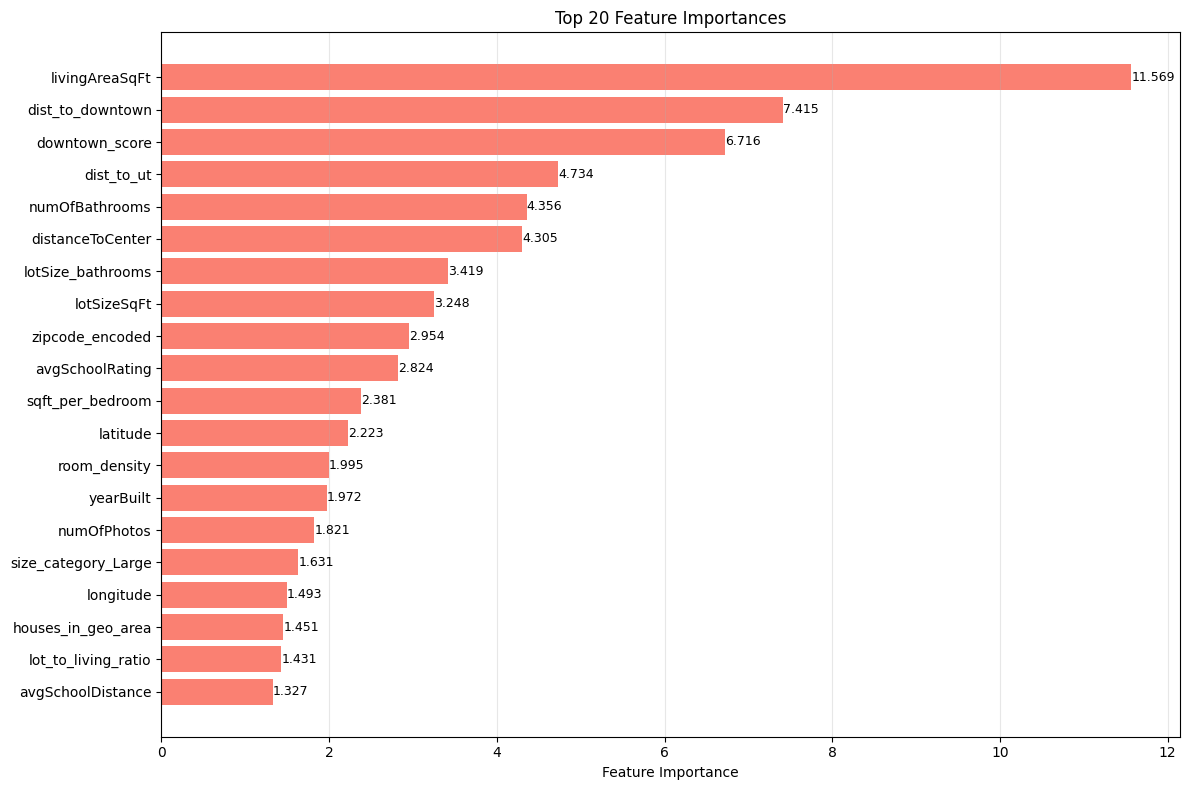

In [95]:
# Feature importance
importances = final_model.feature_importances_

feature_importance = pd.DataFrame({
    'feature': X_clean.columns,
    'importance': importances
}).sort_values('importance', ascending=False)


# Create feature importance plot
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)

# Horizontal bar plot
plt.barh(range(len(top_features)), top_features['importance'], color='salmon')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # Most important at top

# Add value labels on bars
for i, v in enumerate(top_features['importance']):
    plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

In [96]:
def create_folium_price_map(df, sample_size=1000):
    """
    Create interactive map with price-colored markers
    """
    # Sample data for performance (optional)
    if len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=42)
    else:
        df_sample = df.copy()
    
    # Create base map centered on Austin
    austin_center = [30.2672, -97.7431]  # Austin downtown coordinates
    m = folium.Map(location=austin_center, zoom_start=11, tiles='OpenStreetMap')
    
    # Define price bins and colors
    price_bins = [0, 200, 400, 600, 800, 1000, float('inf')]
    colors = ['green', 'lightgreen', 'yellow', 'orange', 'red', 'darkred']
    
    # Add price-colored markers
    for idx, row in df_sample.iterrows():
        if pd.notna(row['latitude']) and pd.notna(row['longitude']):
            # Determine color based on price
            price = row['latestPrice']
            color_idx = 0
            for i, threshold in enumerate(price_bins[1:]):
                if price <= threshold:
                    color_idx = i
                    break
            
            # Create popup text
            popup_text = f"""
            <b>Price: ${price*1000:,.0f}</b><br>
            Living Area: {row['livingAreaSqFt']:,} sqft<br>
            Bedrooms: {row['numOfBedrooms']}<br>
            Bathrooms: {row['numOfBathrooms']}<br>
            Year Built: {row['yearBuilt']}
            """
            
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=5,
                popup=folium.Popup(popup_text, max_width=300),
                color='black',
                weight=1,
                fillColor=colors[color_idx],
                fillOpacity=0.7
            ).add_to(m)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 150px; height: 180px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <b>Price Range (K)</b><br>
    <i class="fa fa-circle" style="color:green"></i> $0-200K<br>
    <i class="fa fa-circle" style="color:lightgreen"></i> $200-400K<br>
    <i class="fa fa-circle" style="color:yellow"></i> $400-600K<br>
    <i class="fa fa-circle" style="color:orange"></i> $600-800K<br>
    <i class="fa fa-circle" style="color:red"></i> $800K-1M<br>
    <i class="fa fa-circle" style="color:darkred"></i> $1M+<br>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m
folium_map = create_folium_price_map(df)
folium_map.save('austin_housing_prices_interactive.html')

# Now we replicate the same features for validation set

In [97]:
# Load the data
df = pd.read_csv('austinhouses_holdout.csv')  

## Basic info about the dataset

In [98]:
print("Dataset Shape:", df.shape)

Dataset Shape: (6785, 35)


In [99]:
print("\nColumn Names:")
for i, col in enumerate(df.columns):
    print(f"{i+1}. {col}")

print("\nData Types:")
print(df.dtypes)

print("\nFirst 5 rows:")
print(df.head())


Column Names:
1. streetAddress
2. zipcode
3. description
4. latitude
5. longitude
6. propertyTaxRate
7. garageSpaces
8. hasAssociation
9. hasGarage
10. hasSpa
11. hasView
12. homeType
13. yearBuilt
14. latestPrice
15. latest_saledate
16. latest_salemonth
17. latest_saleyear
18. numOfPhotos
19. numOfAccessibilityFeatures
20. numOfAppliances
21. numOfParkingFeatures
22. numOfPatioAndPorchFeatures
23. numOfSecurityFeatures
24. numOfWaterfrontFeatures
25. numOfWindowFeatures
26. numOfCommunityFeatures
27. lotSizeSqFt
28. livingAreaSqFt
29. avgSchoolDistance
30. avgSchoolRating
31. avgSchoolSize
32. MedianStudentsPerTeacher
33. numOfBathrooms
34. numOfBedrooms
35. numOfStories

Data Types:
streetAddress                  object
zipcode                         int64
description                    object
latitude                      float64
longitude                     float64
propertyTaxRate               float64
garageSpaces                    int64
hasAssociation                   bool
h

- no missing/null data!

In [100]:
# Look at categorical variables
print("\nCategorical Variables:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col not in ['streetAddress', 'description']:  # Skip these for now
        print(f"\n{col}:")
        print(df[col].value_counts().head())


Categorical Variables:

homeType:
Single Family    6785
Name: homeType, dtype: int64

latest_saledate:
2019-06-28    36
2019-05-31    32
2019-03-29    29
2019-04-30    28
2020-09-16    26
Name: latest_saledate, dtype: int64


- We can drop `homeType` as just has one value 'Single Family', no predictive power!
- Convert date-time object!

In [101]:
df['latest_saledate'] = pd.to_datetime(df['latest_saledate'])
df.drop(['homeType'], axis=1, inplace=True)

## DATA CLEANING AND BASIC PREPROCESSING

In [102]:
# Create a working copy
df_clean = df.copy()

In [103]:
# Remove columns we don't want as predictors (--for now, will do text NLP later if time permits)
columns_to_remove = ['streetAddress', 'description']
df_clean = df_clean.drop(columns=[col for col in columns_to_remove if col in df_clean.columns])

In [104]:
# Look at some basic statistics
print("\nBasic statistics for key variables:")
key_vars = ['livingAreaSqFt', 'lotSizeSqFt', 'numOfBedrooms', 'numOfBathrooms', 'yearBuilt']
for var in key_vars:
    if var in df_clean.columns:
        print(f"{var}: min={df_clean[var].min()}, max={df_clean[var].max()}, mean={df_clean[var].mean():.2f}")



Basic statistics for key variables:
livingAreaSqFt: min=300, max=8880, mean=2149.57
lotSizeSqFt: min=113.0, max=43124.4, mean=9415.72
numOfBedrooms: min=0, max=7, mean=3.46
numOfBathrooms: min=0.0, max=27.0, mean=2.64
yearBuilt: min=1905, max=2020, mean=1987.64


In [105]:
# Convert boolean columns to numeric (0/1)
boolean_cols = ['hasAssociation', 'hasGarage', 'hasSpa', 'hasView']
for col in boolean_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(int)

#  FEATURE ENGINEERING

In [106]:
# Work with cleaned data
df_features = df_clean.copy()

### 1. CREATE RATIO FEATURES

In [107]:
# Sqft per bedroom
# Houses with many bedrooms but small size (cramped layout)
df_features['sqft_per_bedroom'] = df_features['livingAreaSqFt'] / (df_features['numOfBedrooms'] + 0.5)


# Flag houses with unusually low sqft per bedroom (cramped)
sqft_per_bed_q25 = df_features['sqft_per_bedroom'].quantile(0.25)
df_features['is_cramped_layout'] = (df_features['sqft_per_bedroom'] <= sqft_per_bed_q25).astype(int)

cramped_count = df_features['is_cramped_layout'].sum()
print(f"   Found {cramped_count} houses with cramped layouts (≤{sqft_per_bed_q25:.0f} sqft/bedroom)")

   Found 1697 houses with cramped layouts (≤411 sqft/bedroom)


In [108]:
# Lot size to living area ratio (how much land vs house)
df_features['lot_to_living_ratio'] = df_features['lotSizeSqFt'] / (df_features['livingAreaSqFt'] + 1)

In [109]:
# Bathroom to bedroom ratio (layout efficiency)
df_features['bath_bed_ratio'] = df_features['numOfBathrooms'] / (df_features['numOfBedrooms'] + 1)

In [110]:
# Rooms per square foot (density measure)
total_rooms = df_features['numOfBedrooms'] + df_features['numOfBathrooms']
df_features['room_density'] = total_rooms / (df_features['livingAreaSqFt'] + 1)

In [111]:
# very small house indicator 
#  very small houses seem problematic
# Bottom 5% of house sizes
size_bottom_5pct = df_features['livingAreaSqFt'].quantile(0.05)
df_features['is_very_small_house'] = (df_features['livingAreaSqFt'] <= size_bottom_5pct).astype(int)

small_house_count = df_features['is_very_small_house'].sum()
print(f"   Found {small_house_count} very small houses (≤{size_bottom_5pct:.0f} sqft)")

   Found 341 very small houses (≤1023 sqft)


In [112]:
df_features['lotSize_bathrooms'] = df_features['lotSizeSqFt'] * df_features['numOfBathrooms']

### 2. CREATE AGE-RELATED FEATURES

In [113]:
# Age of house
df_features['house_age'] = df_features['latest_saleyear'] - df_features['yearBuilt']

In [114]:
print(f"Houses with negative age: {(df_features['house_age'] < 0).sum()}")
if (df_features['house_age'] < 0).sum() > 0:
    # Set negative ages to 0 (treat as new construction)
    df_features.loc[df_features['house_age'] < 0, 'house_age'] = 0
    print("Fixed negative ages by setting them to 0 (maybe a data entry issue)")

Houses with negative age: 1
Fixed negative ages by setting them to 0 (maybe a data entry issue)


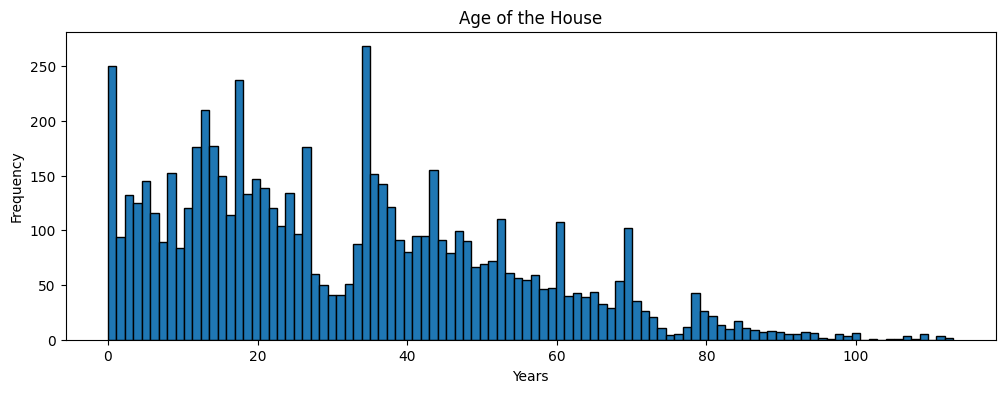

In [115]:
plt.figure(figsize=(12, 4))
plt.hist(df_features['house_age'], bins=100, edgecolor='black')
plt.title('Age of the House')
plt.xlabel('Years')
plt.ylabel('Frequency')
plt.show()

In [116]:
# Create age categories based on your data distribution
# Using quartiles and real estate market understanding
df_features['age_category'] = 'Very Old'  # Default (>45 years, top 25%)

# New construction (0-5 years)
df_features.loc[df_features['house_age'] <= 5, 'age_category'] = 'New'

# Modern (6-14 years) - up to 25th percentile 
df_features.loc[(df_features['house_age'] > 5) & (df_features['house_age'] <= 14), 'age_category'] = 'Modern'

# Established (15-27 years) - 25th to 50th percentile
df_features.loc[(df_features['house_age'] > 14) & (df_features['house_age'] <= 27), 'age_category'] = 'Established'

# Mature (28-45 years) - 50th to 75th percentile  
df_features.loc[(df_features['house_age'] > 27) & (df_features['house_age'] <= 45), 'age_category'] = 'Mature'

# Very Old (>45 years) - top 25% - already set as default

print("Age Categories:")
print(df_features['age_category'].value_counts())

Age Categories:
Very Old       1745
Mature         1619
Established    1551
Modern         1124
New             746
Name: age_category, dtype: int64


Age ranges:
- **New:** 0-5 years
- **Modern:** 6-14 years
- **Established:** 15-27 years
- **Mature:** 28-45 years
- **Very Old:** 46+ years

In [117]:
# Old house with many bedrooms
# Old houses (built before 1980) with many bedrooms (4+) might have layout issues which affect the price
df_features['old_house_many_beds'] = (
    (df_features['yearBuilt'] <= 1980) & 
    (df_features['numOfBedrooms'] >= 4)
).astype(int)

old_many_beds = df_features['old_house_many_beds'].sum()
print(f"   Found {old_many_beds} old houses (≤1980) with 4+ bedrooms")

   Found 640 old houses (≤1980) with 4+ bedrooms


### 3. CREATE AMENITY FEATURES


In [118]:
# Count all the "numOf" feature columns
amenity_cols = [col for col in df_features.columns if col.startswith('numOf') and 'Features' in col]
print(f"Found amenity columns: {amenity_cols}")

Found amenity columns: ['numOfAccessibilityFeatures', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures', 'numOfWaterfrontFeatures', 'numOfWindowFeatures', 'numOfCommunityFeatures']


In [119]:
df_features['total_amenities'] = df_features[amenity_cols].sum(axis=1)

In [120]:
# Count luxury features -- maybe Garage is not a luxury, can remove later!
luxury_features = ['hasSpa', 'hasView', 'hasGarage']
df_features['luxury_score'] = df_features[luxury_features].sum(axis=1)

### 4. LOCATION-BASED FEATURES

In [121]:
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate great circle distance between two points on Earth (decimal degrees)
    Returns distance in miles
    """
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = (math.sin(dlat / 2) ** 2 +
         math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2)
    
    c = 2 * math.asin(math.sqrt(a))
    r = 3959  # Radius of Earth in miles
    
    return c * r

- **DISTANCE TO DOWNTOWN AUSTIN**

In [122]:
# Austin coordinates
downtown_austin_lat = 30.2672
downtown_austin_lon = -97.7431
airport_lat = 30.1975
airport_lon = -97.6664
ut_lat = 30.2849
ut_lon = -97.7341

# Calculate all distances using the same function
df_features['dist_to_downtown'] = df_features.apply(
    lambda row: haversine_distance(row['latitude'], row['longitude'], 
                                 downtown_austin_lat, downtown_austin_lon), axis=1
)

df_features['distanceToCenter'] = df_features.apply(
    lambda row: haversine_distance(row['latitude'], row['longitude'], 
                                 downtown_austin_lat, downtown_austin_lon), axis=1
)

df_features['dist_to_airport'] = df_features.apply(
    lambda row: haversine_distance(row['latitude'], row['longitude'], 
                                 airport_lat, airport_lon), axis=1
)

df_features['dist_to_ut'] = df_features.apply(
    lambda row: haversine_distance(row['latitude'], row['longitude'], 
                                 ut_lat, ut_lon), axis=1
)

print(f"Distance to downtown - Mean: {df_features['dist_to_downtown'].mean():.2f} miles, Max: {df_features['dist_to_downtown'].max():.2f}")
print(f"Distance to airport - Mean: {df_features['dist_to_airport'].mean():.2f} miles, Max: {df_features['dist_to_airport'].max():.2f}")
print(f"Distance to UT - Mean: {df_features['dist_to_ut'].mean():.2f} miles, Max: {df_features['dist_to_ut'].max():.2f}")

Distance to downtown - Mean: 7.97 miles, Max: 17.26
Distance to airport - Mean: 11.67 miles, Max: 22.58
Distance to UT - Mean: 7.95 miles, Max: 18.05


In [123]:
print(f"\nLocation feature correlations with price:")
location_price_corr = df_features[['dist_to_downtown', 'dist_to_ut', 'dist_to_airport', 
                                  'latestPrice']].corr()['latestPrice'].sort_values()

for feature, corr in location_price_corr.items():
    if feature != 'latestPrice':
        print(f"  {feature}: {corr:.3f}")


Location feature correlations with price:
  dist_to_downtown: nan
  dist_to_ut: nan
  dist_to_airport: nan


- **CARDINAL DIRECTION FROM DOWNTOWN**

In [124]:
def get_direction_from_downtown(lat, lon):
    """Get cardinal direction from downtown Austin"""
    lat_diff = lat - downtown_austin_lat
    lon_diff = lon - downtown_austin_lon
    
    # Calculate angle in degrees
    angle = math.degrees(math.atan2(lat_diff, lon_diff))
    
    # Convert to cardinal directions
    if -22.5 <= angle < 22.5:
        return "East"
    elif 22.5 <= angle < 67.5:
        return "Northeast"
    elif 67.5 <= angle < 112.5:
        return "North"
    elif 112.5 <= angle < 157.5:
        return "Northwest"
    elif 157.5 <= angle or angle < -157.5:
        return "West"
    elif -157.5 <= angle < -112.5:
        return "Southwest"
    elif -112.5 <= angle < -67.5:
        return "South"
    else:  # -67.5 <= angle < -22.5
        return "Southeast"

df_features['direction_from_downtown'] = df_features.apply(
    lambda row: get_direction_from_downtown(row['latitude'], row['longitude']) 
    if not pd.isna(row['latitude']) else 'Unknown', axis=1
)

print("Direction distribution:")
print(df_features['direction_from_downtown'].value_counts())


Direction distribution:
North        1753
Southwest    1732
Northeast     859
Northwest     754
West          647
South         468
East          410
Southeast     162
Name: direction_from_downtown, dtype: int64


- **CREATE LOCATION CONVENIENCE SCORE**

In [125]:
# Closer to downtown/UT = higher score, closer to airport = medium score
# Normalize distances to 0-1 scale and invert (closer = higher score)
max_downtown_dist = df_features['dist_to_downtown'].max()
max_ut_dist = df_features['dist_to_ut'].max()
max_airport_dist = df_features['dist_to_airport'].max()

df_features['downtown_score'] = 1 - (df_features['dist_to_downtown'] / max_downtown_dist)
df_features['airport_score'] = 1 - (df_features['dist_to_airport'] / max_airport_dist)


- **Geographic Density Outlier**

In [126]:
# Create lat/lon bins and count houses in each
df_features['lat_bin'] = pd.cut(df_features['latitude'], bins=20, labels=False)
df_features['lon_bin'] = pd.cut(df_features['longitude'], bins=20, labels=False)

# Count houses in same geographic bin
df_features['geo_bin'] = df_features['lat_bin'].astype(str) + '_' + df_features['lon_bin'].astype(str)
geo_bin_counts = df_features['geo_bin'].value_counts()
df_features['houses_in_geo_area'] = df_features['geo_bin'].map(geo_bin_counts)

# Flag houses in very sparse areas (potential data quality issues)
df_features['is_isolated_location'] = (df_features['houses_in_geo_area'] <= 2).astype(int)

isolated_count = df_features['is_isolated_location'].sum()
print(f"   Found {isolated_count} houses in isolated locations (≤2 houses nearby)")

   Found 34 houses in isolated locations (≤2 houses nearby)


- **Distance - Size Interaction**

In [127]:
# Small houses far from downtown might be problematic
df_features['small_house_far_downtown'] = (
    (df_features['livingAreaSqFt'] <= 1500) & 
    (df_features['dist_to_downtown'] >= 10.0)
).astype(int)

# Large houses very close to downtown
df_features['large_house_close_downtown'] = (
    (df_features['livingAreaSqFt'] >= 4000) & 
    (df_features['dist_to_downtown'] <= 3.0)
).astype(int)

small_far = df_features['small_house_far_downtown'].sum()
large_close = df_features['large_house_close_downtown'].sum()
print(f"   Small houses far from downtown: {small_far}")
print(f"   Large houses close to downtown: {large_close}")

   Small houses far from downtown: 158
   Large houses close to downtown: 20


- **Bathroom - Bedroom Ratio**

In [128]:
# Very low ratio (not enough bathrooms) or very high ratio (too many bathrooms)
ratio_q10 = df_features['bath_bed_ratio'].quantile(0.10)
ratio_q90 = df_features['bath_bed_ratio'].quantile(0.90)

df_features['extreme_bath_bed_ratio'] = (
(df_features['bath_bed_ratio'] <= ratio_q10) | 
(df_features['bath_bed_ratio'] >= ratio_q90)
).astype(int)

extreme_ratio = df_features['extreme_bath_bed_ratio'].sum()
print(f"   Houses with extreme bath-bed ratios: {extreme_ratio}")

   Houses with extreme bath-bed ratios: 1817


- **Very old/Very new built**

In [129]:
# Very old houses (bottom 5%) or very new houses (top 5%) might be special
year_bottom_5 = df_features['yearBuilt'].quantile(0.05)
year_top_95 = df_features['yearBuilt'].quantile(0.95)

df_features['is_very_old_house'] = (df_features['yearBuilt'] <= year_bottom_5).astype(int)
df_features['is_very_new_house'] = (df_features['yearBuilt'] >= year_top_95).astype(int)

very_old = df_features['is_very_old_house'].sum()
very_new = df_features['is_very_new_house'].sum()
print(f"   Very old houses (≤{year_bottom_5:.0f}): {very_old}")
print(f"   Very new houses (≥{year_top_95:.0f}): {very_new}")

   Very old houses (≤1948): 343
   Very new houses (≥2017): 385


- **From your residual analysis: very large houses (5000+ sqft) also have high residuals**


In [130]:
# Top 5% of house sizes
size_top_5pct = df_features['livingAreaSqFt'].quantile(0.95)
df_features['is_very_large_house'] = (df_features['livingAreaSqFt'] >= size_top_5pct).astype(int)

large_house_count = df_features['is_very_large_house'].sum()
print(f"   Found {large_house_count} very large houses (≥{size_top_5pct:.0f} sqft)")

# Also flag extreme outliers (top 1%)
size_top_1pct = df_features['livingAreaSqFt'].quantile(0.99)
df_features['is_mansion_size'] = (df_features['livingAreaSqFt'] >= size_top_1pct).astype(int)

mansion_count = df_features['is_mansion_size'].sum()
print(f"   Found {mansion_count} mansion-sized houses (≥{size_top_1pct:.0f} sqft)")

   Found 341 very large houses (≥3852 sqft)
   Found 68 mansion-sized houses (≥4920 sqft)


- **Very recent construction**

In [131]:
# very recent houses (2010+) have high residuals
# Houses built in last 15 years
current_year = 2025
df_features['is_recently_built'] = (df_features['yearBuilt'] >= 2010).astype(int)

# Houses built in last 5 years (very new)
df_features['is_brand_new'] = (df_features['yearBuilt'] >= 2020).astype(int)

recent_count = df_features['is_recently_built'].sum()
brand_new_count = df_features['is_brand_new'].sum()
print(f"   Recently built houses (≥2010): {recent_count}")
print(f"   Brand new houses (≥2020): {brand_new_count}")

   Recently built houses (≥2010): 1104
   Brand new houses (≥2020): 59


- **Size extreme flags!**

In [132]:
# Both very small AND very large houses seem problematic
size_bottom_5pct = df_features['livingAreaSqFt'].quantile(0.05)
size_top_5pct = df_features['livingAreaSqFt'].quantile(0.95)

df_features['is_extreme_size'] = (
    (df_features['livingAreaSqFt'] <= size_bottom_5pct) |
    (df_features['livingAreaSqFt'] >= size_top_5pct)
).astype(int)

extreme_size_count = df_features['is_extreme_size'].sum()
print(f"   Houses with extreme sizes (very small OR very large): {extreme_size_count}")

   Houses with extreme sizes (very small OR very large): 682


- **New, Large houses!** 

In [133]:
# New, large houses might be especially problematic
df_features['new_large_house'] = (
(df_features['yearBuilt'] >= 2010) &
(df_features['livingAreaSqFt'] >= 4000)
).astype(int)

new_large_count = df_features['new_large_house'].sum()
print(f"   New large houses (≥2010 & ≥4000 sqft): {new_large_count}")

   New large houses (≥2010 & ≥4000 sqft): 62


### 5. SCHOOL-RELATED FEATURES

In [134]:
# Create school rating categories (more interpretable than normalization)
df_features['school_tier'] = 'Average'  # Default
df_features.loc[df_features['avgSchoolRating'] <= 4.0, 'school_tier'] = 'Below Average'  # Bottom 25%
df_features.loc[df_features['avgSchoolRating'] >= 7.0, 'school_tier'] = 'Above Average'  # Top 25%
df_features.loc[df_features['avgSchoolRating'] >= 8.5, 'school_tier'] = 'Excellent'     # Top schools

print(df_features['school_tier'].value_counts())

Average          2565
Below Average    1860
Above Average    1776
Excellent         584
Name: school_tier, dtype: int64


In [135]:
# Teacher-student ratio: lower is better
# Create a simple "teacher attention" score (invert the ratio)
# Higher score = more teacher attention (lower student-teacher ratio)
max_ratio = df_features['MedianStudentsPerTeacher'].max()
df_features['teacher_attention_score'] = max_ratio - df_features['MedianStudentsPerTeacher']

### 6. SIZE CATEGORIES

In [136]:
print(f"Living area distribution:")
print(df_features['livingAreaSqFt'].describe())

# Create size categories based on your quartiles and market reality
df_features['size_category'] = 'Large'  # Default for >75th percentile

# Small: Up to 25th percentile (≤1496 sqft)
df_features.loc[df_features['livingAreaSqFt'] <= 1496, 'size_category'] = 'Small'

# Medium: 25th to 75th percentile (1497-2645 sqft) 
df_features.loc[(df_features['livingAreaSqFt'] > 1496) & 
                (df_features['livingAreaSqFt'] <= 2645), 'size_category'] = 'Medium'

# Large: Above 75th percentile (>2645 sqft) - already set as default

# Extra Large: Top 5% (very large homes)
top_95_percentile = df_features['livingAreaSqFt'].quantile(0.95)
df_features.loc[df_features['livingAreaSqFt'] > top_95_percentile, 'size_category'] = 'Extra Large'

print("Size Category")
print(df_features['size_category'].value_counts())


Living area distribution:
count    6785.000000
mean     2149.565954
std       912.010985
min       300.000000
25%      1483.000000
50%      1961.000000
75%      2649.000000
max      8880.000000
Name: livingAreaSqFt, dtype: float64
Size Category
Medium         3346
Small          1738
Large          1363
Extra Large     338
Name: size_category, dtype: int64


Size ranges:
- Small: ≤1,496 sqft (bottom 25%)
- Medium: 1,497-2,645 sqft (middle 50%)
- Large: 2,646-{top_95_percentile:.0f} sqft (75th-95th percentile)
- Extra Large: >{top_95_percentile:.0f} sqft (top 5%)


### TEXT MINING FROM PROPERTY DESCRIPTIONS

In [137]:
df_text = df.copy()
# Fill missing descriptions
df_text['description'] = df_text['description'].fillna('')
df_text['description_clean'] = df_text['description'].str.lower()

In [138]:
# ================================================================
# PHASE 1: BASIC TEXT MINING (KEYWORD EXTRACTION)
# ================================================================

In [139]:
# LUXURY KEYWORDS
luxury_keywords = [
    'granite', 'quartz', 'marble', 'hardwood', 'upgraded', 'custom', 'luxury',
    'premium', 'high-end', 'stainless', 'gourmet', 'spa', 'pool', 'fireplace',
    'crown molding', 'coffered', 'vaulted', 'cathedral', 'master suite',
    'walk-in closet', 'double vanity', 'jetted tub', 'steam shower'
]

luxury_count = 0
for keyword in luxury_keywords:
    df_text[f'has_{keyword.replace(" ", "_").replace("-", "_")}'] = df_text['description_clean'].str.contains(keyword, na=False).astype(int)
    count = df_text[f'has_{keyword.replace(" ", "_").replace("-", "_")}'].sum()
    if count > 0:
        luxury_count += 1

luxury_cols = [col for col in df_text.columns if col.startswith('has_') and any(kw.replace(" ", "_").replace("-", "_") in col for kw in luxury_keywords)]
df_text['description_luxury_score'] = df_text[luxury_cols].sum(axis=1)

print(f"Created {len(luxury_cols)} luxury keyword features")

Created 23 luxury keyword features


In [140]:
# CONDITION KEYWORDS
condition_keywords = {
    'excellent': ['move-in ready', 'pristine', 'immaculate', 'stunning', 'gorgeous', 'beautiful'],
    'updated': ['renovated', 'remodeled', 'updated', 'new flooring', 'fresh paint', 'recent'],
    'issues': ['needs work', 'fixer', 'as-is', 'handyman', 'tlc', 'potential']
}

for condition, keywords in condition_keywords.items():
    df_text[f'condition_{condition}'] = 0
    for keyword in keywords:
        df_text[f'condition_{condition}'] += df_text['description_clean'].str.contains(keyword, na=False).astype(int)
    df_text[f'condition_{condition}'] = (df_text[f'condition_{condition}'] > 0).astype(int)

In [141]:
#  DESCRIPTION QUALITY
df_text['description_length'] = df_text['description'].str.len()
df_text['description_word_count'] = df_text['description'].str.split().str.len()
df_text['description_exclamation_count'] = df_text['description'].str.count('!')


In [142]:
# LOCATION MENTIONS
location_keywords = [
    'downtown', 'airport', 'shopping', 'school', 'park', 'trail', 'lake',
    'river', 'highway', 'toll', 'minutes to', 'close to', 'walking distance'
]

for keyword in location_keywords:
    df_text[f'near_{keyword.replace(" ", "_")}'] = df_text['description_clean'].str.contains(keyword, na=False).astype(int)

location_cols = [col for col in df_text.columns if col.startswith('near_')]
df_text['description_location_score'] = df_text[location_cols].sum(axis=1)



In [143]:
# 6. SPECIFIC HIGH-VALUE FEATURES
specific_features = {
    'pool_mentioned': ['pool', 'swimming'],
    'garage_mentioned': ['garage', 'car garage', 'parking'],
    'kitchen_quality': ['gourmet kitchen', 'chef kitchen', 'island', 'breakfast bar'],
    'master_luxury': ['master suite', 'master bedroom', 'en-suite', 'walk-in shower']
}
for feature, keywords in specific_features.items():
    df_text[feature] = 0
    for keyword in keywords:
        df_text[feature] += df_text['description_clean'].str.contains(keyword, na=False).astype(int)
    df_text[feature] = (df_text[feature] > 0).astype(int)


In [144]:
# BASIC TEXT FEATURES SUMMARY
basic_text_features = []
basic_text_features.extend(luxury_cols)
basic_text_features.extend([f'condition_{c}' for c in condition_keywords.keys()])
basic_text_features.extend(location_cols)
basic_text_features.extend(['description_length', 'description_word_count', 'description_exclamation_count', 'description_caps_ratio'])
basic_text_features.extend(['description_luxury_score', 'description_outdoor_score', 'description_location_score'])
basic_text_features.extend(list(specific_features.keys()))

print(f"\nPhase 1 Summary: Created {len(basic_text_features)} basic text features")



Phase 1 Summary: Created 50 basic text features


In [145]:
# ================================================================
# PHASE 2: ADVANCED NLP
# ================================================================

In [146]:
# Advanced text preprocessing

def advanced_text_preprocessing(text):
    text = text.lower()
    text = re.sub(r'[^\w\s\-]', ' ', text)
    text = ' '.join(text.split())
    words = [word for word in text.split() if len(word) >= 3]
    return ' '.join(words)

descriptions_clean_advanced = df_text['description'].apply(advanced_text_preprocessing)

In [147]:
#  TF-IDF FEATURES

# Unigram TF-IDF
tfidf_unigram = TfidfVectorizer(
    max_features=50,   # Reduced to avoid overfitting
    min_df=5,
    max_df=0.8,
    ngram_range=(1,1),
    stop_words='english'
)

tfidf_unigram_matrix = tfidf_unigram.fit_transform(descriptions_clean_advanced)

# Bigram TF-IDF
tfidf_bigram = TfidfVectorizer(
    max_features=25,   # Smaller for bigrams
    min_df=3,
    max_df=0.7,
    ngram_range=(2,2),
    stop_words='english'
)
tfidf_bigram_matrix = tfidf_bigram.fit_transform(descriptions_clean_advanced)

print(f"Created {tfidf_unigram_matrix.shape[1]} unigram and {tfidf_bigram_matrix.shape[1]} bigram TF-IDF features")

Created 50 unigram and 25 bigram TF-IDF features


In [148]:
#  DIMENSIONALITY REDUCTION

# Reduce TF-IDF to manageable dimensions
n_components_uni = min(15, tfidf_unigram_matrix.shape[1])
n_components_bi = min(10, tfidf_bigram_matrix.shape[1])

if n_components_uni > 1:
    svd_unigram = TruncatedSVD(n_components=n_components_uni, random_state=42)
    tfidf_unigram_reduced = svd_unigram.fit_transform(tfidf_unigram_matrix)
    
    for i in range(n_components_uni):
        df_text[f'tfidf_unigram_svd_{i}'] = tfidf_unigram_reduced[:, i]

if n_components_bi > 1:
    svd_bigram = TruncatedSVD(n_components=n_components_bi, random_state=42)
    tfidf_bigram_reduced = svd_bigram.fit_transform(tfidf_bigram_matrix)
    
    for i in range(n_components_bi):
        df_text[f'tfidf_bigram_svd_{i}'] = tfidf_bigram_reduced[:, i]

In [149]:
#  REAL ESTATE PHRASE PATTERNS

real_estate_phrases = [
    (r'move[\s\-]*in[\s\-]*ready', 'move_in_ready'),
    (r'recently[\s\-]*updated', 'recently_updated'),
    (r'granite[\s\-]*counter', 'granite_counter'),
    (r'hardwood[\s\-]*floor', 'hardwood_floor'),
    (r'stainless[\s\-]*steel', 'stainless_steel'),
    (r'open[\s\-]*floor[\s\-]*plan', 'open_floor_plan'),
    (r'master[\s\-]*suite', 'master_suite_phrase'),
    (r'walk[\s\-]*in[\s\-]*closet', 'walk_in_closet'),
    (r'covered[\s\-]*patio', 'covered_patio'),
    (r'fenced[\s\-]*yard', 'fenced_yard'),
    (r'corner[\s\-]*lot', 'corner_lot'),
    (r'cul[\s\-]*de[\s\-]*sac', 'cul_de_sac')
]

for phrase_pattern, phrase_name in real_estate_phrases:
    df_text[f'phrase_{phrase_name}'] = descriptions_clean_advanced.str.contains(phrase_pattern, regex=True, na=False).astype(int)


In [150]:
#  SIMPLE TEXT EMBEDDINGS

def create_simple_embeddings(descriptions, vocab_size=20):
    vectorizer = CountVectorizer(max_features=vocab_size, stop_words='english', min_df=3)
    word_matrix = vectorizer.fit_transform(descriptions)
    
    vocab = vectorizer.get_feature_names_out()
    doc_freq = np.array(word_matrix.sum(axis=0)).flatten()
    idf = np.log(len(descriptions) / (doc_freq + 1))
    
    embeddings = np.zeros((len(descriptions), vocab_size))
    
    for i, desc in enumerate(descriptions):
        words = desc.split()
        for word in words:
            if word in vocab:
                word_idx = list(vocab).index(word)
                embeddings[i, word_idx] += idf[word_idx]
    
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    embeddings = embeddings / (norms + 1e-8)
    
    return embeddings

embeddings = create_simple_embeddings(descriptions_clean_advanced, vocab_size=15)

for i in range(embeddings.shape[1]):
    df_text[f'text_embedding_{i}'] = embeddings[:, i]

In [151]:
# 2.6 SENTIMENT AND STYLE

positive_words = ['beautiful', 'stunning', 'gorgeous', 'amazing', 'perfect', 'excellent', 'fantastic', 'wonderful']
negative_words = ['needs', 'fixer', 'repair', 'tlc', 'work', 'older', 'dated']

df_text['positive_sentiment_count'] = sum(descriptions_clean_advanced.str.count(word) for word in positive_words)
df_text['negative_sentiment_count'] = sum(descriptions_clean_advanced.str.count(word) for word in negative_words)
df_text['sentiment_ratio'] = (df_text['positive_sentiment_count'] + 1) / (df_text['negative_sentiment_count'] + 1)

# Marketing style
df_text['caps_words_count'] = df_text['description'].str.count(r'\b[A-Z]{2,}\b')
df_text['exclamation_density'] = df_text['description'].str.count('!') / (df_text['description_length'] + 1)


In [152]:
# ADVANCED TEXT FEATURES SUMMARY
advanced_text_features = []
advanced_text_features.extend([f'tfidf_unigram_svd_{i}' for i in range(n_components_uni)])
advanced_text_features.extend([f'tfidf_bigram_svd_{i}' for i in range(n_components_bi)])
advanced_text_features.extend([f'phrase_{name}' for _, name in real_estate_phrases])
advanced_text_features.extend([f'text_embedding_{i}' for i in range(embeddings.shape[1])])
advanced_text_features.extend(['positive_sentiment_count', 'negative_sentiment_count', 'sentiment_ratio', 'caps_words_count', 'exclamation_density'])

print(f"\nPhase 2 Summary: Created {len(advanced_text_features)} advanced NLP features")


Phase 2 Summary: Created 57 advanced NLP features


In [153]:
good_text_features = ['has_granite',
 'has_marble',
 'has_hardwood',
 'has_custom',
 'has_luxury',
 'has_high_end',
 'has_gourmet',
 'has_spa',
 'has_pool',
 'has_master_suite',
 'has_steam_shower',
 'condition_excellent',
 'condition_updated',
 'near_airport',
 'near_shopping',
 'near_lake',
 'near_toll',
 'near_close_to',
 'description_length',
 'description_word_count',
 'description_exclamation_count',
 'description_luxury_score',
 'pool_mentioned',
 'kitchen_quality',
 'master_luxury',
 'tfidf_unigram_svd_2',
 'tfidf_unigram_svd_3',
 'tfidf_unigram_svd_6',
 'tfidf_unigram_svd_9',
 'tfidf_unigram_svd_14',
 'tfidf_bigram_svd_4',
 'phrase_granite_counter',
 'phrase_master_suite_phrase',
 'text_embedding_2',
 'text_embedding_9',
 'text_embedding_11',
 'text_embedding_13',
 'positive_sentiment_count',
 'sentiment_ratio',
 'exclamation_density']
# Add good text features to main dataset
for feature in good_text_features:
    df_features[feature] = df_text[feature]

print(f"Added {len(good_text_features)} high-correlation text features to main dataset")

Added 40 high-correlation text features to main dataset


### 7. ENCODE CATEGORICAL VARIABLES

In [154]:
categorical_encode = ['age_category', 'size_category', 'direction_from_downtown', 'school_tier']

for cat_col in categorical_encode:
    if cat_col in df_features.columns:
        dummies = pd.get_dummies(df_features[cat_col], prefix=cat_col)
        df_features = pd.concat([df_features, dummies], axis=1)


In [155]:
le_zip = LabelEncoder()
df_features['zipcode_encoded'] = le_zip.fit_transform(df_features['zipcode'].astype(str))
df_features = df_features.drop('zipcode', axis=1)

In [156]:
new_numeric_features = [
    'lot_to_living_ratio', 'bath_bed_ratio', 'house_age',
    'total_amenities', 'luxury_score', 'school_quality_score','room_density','lotSize_bathrooms'
]

print(f"Original features: {df_clean.shape[1]}")
print(f"After feature engineering: {df_features.shape[1]}")
print(f"New features added: {df_features.shape[1] - df_clean.shape[1]}")

Original features: 32
After feature engineering: 131
New features added: 99


In [157]:
# Check for any infinite or NaN values in new features
print(f"\nChecking for infinite values: {np.isinf(df_features.select_dtypes(include=[np.number])).sum().sum()}")
print(f"Checking for NaN values: {df_features.isnull().sum().sum()}")



Checking for infinite values: 0
Checking for NaN values: 6785


In [158]:
df_features

,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasGarage,hasSpa,hasView,yearBuilt,latestPrice,latest_saledate,latest_salemonth,latest_saleyear,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,sqft_per_bedroom,is_cramped_layout,lot_to_living_ratio,bath_bed_ratio,room_density,is_very_small_house,lotSize_bathrooms,house_age,age_category,old_house_many_beds,total_amenities,luxury_score,dist_to_downtown,distanceToCenter,dist_to_airport,dist_to_ut,direction_from_downtown,downtown_score,airport_score,lat_bin,lon_bin,geo_bin,houses_in_geo_area,is_isolated_location,small_house_far_downtown,large_house_close_downtown,extreme_bath_bed_ratio,is_very_old_house,is_very_new_house,is_very_large_house,is_mansion_size,is_recently_built,is_brand_new,is_extreme_size,new_large_house,school_tier,teacher_attention_score,size_category,has_granite,has_marble,has_hardwood,has_custom,has_luxury,has_high_end,has_gourmet,has_spa,has_pool,has_master_suite,has_steam_shower,condition_excellent,condition_updated,near_airport,near_shopping,near_lake,near_toll,near_close_to,description_length,description_word_count,description_exclamation_count,description_luxury_score,pool_mentioned,kitchen_quality,master_luxury,tfidf_unigram_svd_2,tfidf_unigram_svd_3,tfidf_unigram_svd_6,tfidf_unigram_svd_9,tfidf_unigram_svd_14,tfidf_bigram_svd_4,phrase_granite_counter,phrase_master_suite_phrase,text_embedding_2,text_embedding_9,text_embedding_11,text_embedding_13,positive_sentiment_count,sentiment_ratio,exclamation_density,age_category_Established,age_category_Mature,age_category_Modern,age_category_New,age_category_Very Old,size_category_Extra Large,size_category_Large,size_category_Medium,size_category_Small,direction_from_downtown_East,direction_from_downtown_North,direction_from_downtown_Northeast,direction_from_downtown_Northwest,direction_from_downtown_South,direction_from_downtown_Southeast,direction_from_downtown_Southwest,direction_from_downtown_West,school_tier_Above Average,school_tier_Average,school_tier_Below Average,school_tier_Excellent,zipcode_encoded
0,30.218447,-97.865906,1.98,0,0,0,0,0,1992,NaN,2018-11-15,11,2018,30,0,0,1,0,0,0,0,0,7623.0,2516,1.566667,8.000000,1655,17,3.0,3,2,718.857143,0,3.028605,0.75,0.002384,0,22869.0,26,Established,0,1,0,8.067667,8.067667,12.000977,9.109187,West,0.532476,0.468620,4,6,4_6,96,0,0,0,0,0,0,0,0,0,0,0,0,Above Average,2,Medium,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,403,64,6,1,0,0,0,0.019363,-0.080467,-0.359332,0.171454,-0.032637,-0.187142,0,0,0.000000,0.450268,0.353638,0.598354,1,2.000000,0.014851,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,32
1,30.188887,-97.990784,2.01,3,1,1,0,0,2015,NaN,2018-04-19,4,2018,35,0,4,2,0,0,0,0,0,16552.8,3497,4.200000,6.000000,777,16,4.0,4,1,777.111111,0,4.732075,0.80,0.002287,0,66211.2,3,New,0,2,1,15.746280,15.746280,19.382440,16.697747,West,0.087497,0.141784,3,0,3_0,40,0,0,0,1,0,0,0,0,1,0,0,0,Average,3,Large,1,0,1,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1581,228,4,8,1,1,0,-0.058308,0.147935,0.078804,-0.014074,-0.219262,-0.005602,1,0,0.000000,0.380147,0.298565,0.252585,2,1.500000,0.002528,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,23
2,30.281693,-97.688553,1.98,1,0,1,0,0,1968,NaN,2018-06-01,6,2018,2,0,4,2,0,0,0,0,0,5793.0,1064,2.000000,3.333333,635,13,2.0,3,1,304.000000,1,5.439437,0.50,0.004695,0,11586.0,50,Very Old,0,2,1,3.405606,3.405606,5.965910,2.726761,East,0.802644,0.735841,7,14,7_14,92,0,0,0,0,0,0,0,0,0,0,0,0,Below Average,6,Small,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,240,43,0,0,0,0,0,-0.001296,-0.011793,-0.000906,-0.006220,0.003924,0.001077,0,0,0.318303,0.000000,0.000000,0.000000,0,1.000000,0.000000,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,7
3,30.363327,-97.853149,1.98,3,1,1,0,0,1999,NaN,2019-05-20,5,2019,43

In [159]:
print(list(df_features.columns))


['latitude', 'longitude', 'propertyTaxRate', 'garageSpaces', 'hasAssociation', 'hasGarage', 'hasSpa', 'hasView', 'yearBuilt', 'latestPrice', 'latest_saledate', 'latest_salemonth', 'latest_saleyear', 'numOfPhotos', 'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures', 'numOfWaterfrontFeatures', 'numOfWindowFeatures', 'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms', 'numOfBedrooms', 'numOfStories', 'sqft_per_bedroom', 'is_cramped_layout', 'lot_to_living_ratio', 'bath_bed_ratio', 'room_density', 'is_very_small_house', 'lotSize_bathrooms', 'house_age', 'age_category', 'old_house_many_beds', 'total_amenities', 'luxury_score', 'dist_to_downtown', 'distanceToCenter', 'dist_to_airport', 'dist_to_ut', 'direction_from_downtown', 'downtown_score', 'airport_score', 'lat_bin', 'lon_bin', 'geo_bin', 'houses_in_geo_a

In [160]:
exclude_cols = [
    'latestPrice', 
    'latest_saledate', 'latest_salemonth', 'latest_saleyear',
    'streetAddress', 'description', 'description_clean',
    'homeType', 'age_category', 'zipcode_tier', 'size_category', 'school_tier','geo_bin',
    'direction_from_downtown',  
    'zipcode'
]

exclude_cols = [col for col in exclude_cols if col in df_features.columns]

# Create feature matrix
X_holdout = df_features.drop(columns=exclude_cols)


In [161]:
final_model = CatBoostRegressor()
final_model.load_model('catboost_model.cbm')

predictions = final_model.predict(X_holdout)

print(predictions)

[449.24761519 567.46951711 294.99525817 ... 284.78833529 423.58471114
 453.14942336]


In [162]:
predictions

array([449.24761519, 567.46951711, 294.99525817, ..., 284.78833529,
       423.58471114, 453.14942336])

In [163]:
pd.DataFrame({'predicted_price': predictions}).to_csv('predicted_prices.csv')

# THANK YOU :) 